# Testing notebook for work carried out by George 

Owner: George Hine

email: ppygh3@nottingham.ac.uk

Set path and Imports:

In [1]:
import sys
sys.path.append('..')


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


In [3]:
from gax import sersic
from gax.sersic import sersic_2d_linear_pix
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import astropy
import numpy as np
from astropy.table import Table, vstack
import gax_fits as gfits
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator

bands = np.array(['u','g','r','i','z'])
wavs = np.array([354.3e-9, 477.0e-9, 623.1e-9, 762.5e-9, 913.4e-9], dtype=float)



In [4]:
# First import a good spiral
img = gfits.Read('/home/borge/Data/Test_batch/587726031719301138ra.fits.gz')

In [5]:
# Now import fit table
Tab = gfits.Read_Table('/home/borge/Data/Output_Data/Distributed_run/587726031719301138ra/0200/source_params.fits')

In [6]:
# Find information from Table

x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
log_R_e = np.asarray(Tab['log_re'])
log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*0.5)
log_R_e_2 = np.log(10**np.asarray(Tab['log_re'])*2)
pa = np.asarray(Tab['theta'])
q = np.asarray(Tab['q'])
print(x0,y0,0.45*log_R_e,R_e,log_R_e_2,pa,q)

[[149]] [[190]] [0.85758857] [80.49193542] [5.08130418] [-1.95262411] [0.79551722]


In [7]:
# Get the dimensions of the image
height, width = img.shape[:2]

# Calculate the maximum possible radius
max_radius = min(x0, y0, width-x0, height-y0)
max_R = max_radius -1


Text(0.5, 1.0, '587726031719301138 R ')

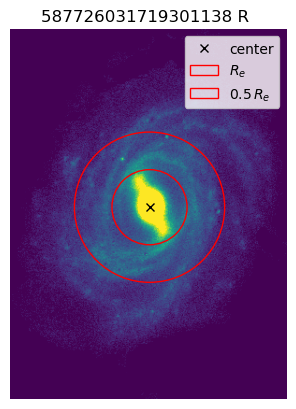

In [8]:
# plot center and R_e on image to have a look
from matplotlib.patches import Circle

fig, ax = plt.subplots()
ax.imshow(img,vmin=1000,vmax=1200)

# Define circle
R_e_1 = Circle((x0,y0),R_e,edgecolor='red', facecolor=None, fill=False)
R_e_05 = Circle((x0,y0),0.5*R_e,edgecolor='red', facecolor=None, fill=False)
R_e_2 = Circle((x0,y0),2*R_e,edgecolor='red', facecolor=None, fill=False)
#r_max = Circle((x0,y0),max_R,edgecolor='red', facecolor=None, fill=False)
ax.plot(x0,y0,'xk')
ax.add_patch(R_e_1)
ax.add_patch(R_e_05)
#ax.add_patch(r_max)
#ax.add_patch(R_e_2)
ax.legend(['center','$R_e$','$0.5\, R_e$'])
ax.axis('off')
ax.set_title('587726031719301138 R ')

In [9]:
y, x = np.indices(img.shape)
print(x,y)

[[  0   1   2 ... 293 294 295]
 [  0   1   2 ... 293 294 295]
 [  0   1   2 ... 293 294 295]
 ...
 [  0   1   2 ... 293 294 295]
 [  0   1   2 ... 293 294 295]
 [  0   1   2 ... 293 294 295]] [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [393 393 393 ... 393 393 393]
 [394 394 394 ... 394 394 394]
 [395 395 395 ... 395 395 395]]


In [10]:
x -= x0
y -= y0
print(x,y)

[[-149 -148 -147 ...  144  145  146]
 [-149 -148 -147 ...  144  145  146]
 [-149 -148 -147 ...  144  145  146]
 ...
 [-149 -148 -147 ...  144  145  146]
 [-149 -148 -147 ...  144  145  146]
 [-149 -148 -147 ...  144  145  146]] [[-190 -190 -190 ... -190 -190 -190]
 [-189 -189 -189 ... -189 -189 -189]
 [-188 -188 -188 ... -188 -188 -188]
 ...
 [ 203  203  203 ...  203  203  203]
 [ 204  204  204 ...  204  204  204]
 [ 205  205  205 ...  205  205  205]]


In [11]:
# Deprojecting x,y by a series of affine transformations

# Rotate by minus position angle
ct = np.cos(-pa)
st = np.sin(-pa)

# Stretch according to axis ratio and rotation
xp = (y * ct + x * st) / q
yp = (-y * st + x * ct)

# Convert to Polar
rp2 = xp ** 2 +  yp ** 2
rp = np.sqrt(rp2)
tp = np.arctan2(yp, xp)

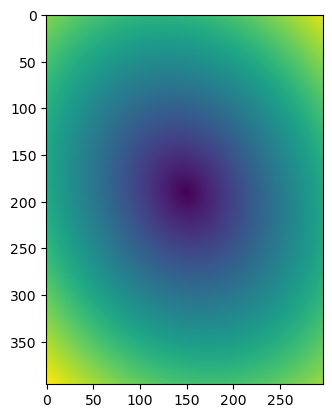

In [12]:
plt.imshow(rp)

In [13]:
n_lnr = 150
n_theta = 150
lnr, theta = np.indices((n_lnr, n_theta))

In [14]:
lnr_min = float(log_R_e_05)
lnr_max = float(np.log(int(max_R) -1))
theta_max = 360
lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
theta = theta * theta_max / n_theta
print(lnr_min,lnr_max)

3.695009817700963 4.976733742420574


In [15]:
xp = np.exp(lnr) * np.sin(np.radians(theta))
yp = np.exp(lnr) * np.cos(np.radians(theta))
print(xp,yp)

[[  0.           1.68532621   3.36769578 ...  -5.04415727  -3.36769578
   -1.68532621]
 [  0.           1.69978873   3.39659545 ...  -5.08744339  -3.39659545
   -1.69978873]
 [  0.           1.71437536   3.42574312 ...  -5.13110097  -3.42574312
   -1.71437536]
 ...
 [  0.           5.9182961   11.8262095  ... -17.7133757  -11.8262095
   -5.9182961 ]
 [  0.           5.96908359  11.92769537 ... -17.86538193 -11.92769537
   -5.96908359]
 [  0.           6.0203069   12.03005214 ... -18.01869258 -12.03005214
   -6.0203069 ]] [[ 40.24596771  40.21066516  40.10481944 ...  39.92861623  40.10481944
   40.21066516]
 [ 40.59133596  40.55573046  40.44897643 ...  40.27126115  40.44897643
   40.55573046]
 [ 40.93966797  40.90375693  40.79608679 ...  40.61684646  40.79608679
   40.90375693]
 ...
 [141.33023779 141.20626716 140.83457276 ... 140.21580666 140.83457276
  141.20626716]
 [142.54305438 142.41801991 142.04313583 ... 141.41905982 142.04313583
  142.41801991]
 [143.76627868 143.64017123 143.2

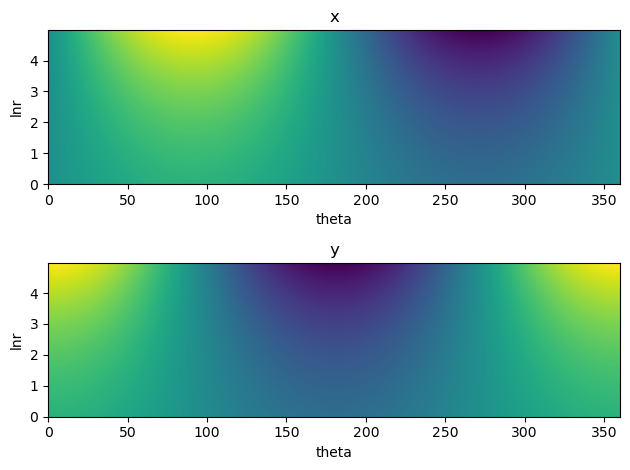

In [16]:
fig, ax = plt.subplots(2)
ax[0].imshow(xp, extent=(0, theta_max, 0, lnr_max), origin='lower', aspect='auto')
ax[1].imshow(yp, extent=(0, theta_max, 0, lnr_max), origin='lower', aspect='auto')
ax[0].set_title('x')
ax[1].set_title('y');
for a in ax:
    a.set_xlabel('theta')
    a.set_ylabel('lnr');
plt.tight_layout()

In [17]:
# this is an attempt at using the above deprojection code
# to do the inverse by pa -> -pa and q -> 1/q
ct = np.cos(pa)
st = np.sin(pa)
x = (yp * ct + xp * st) * q
y = (-yp * st + xp * ct)
x += y0
y += x0


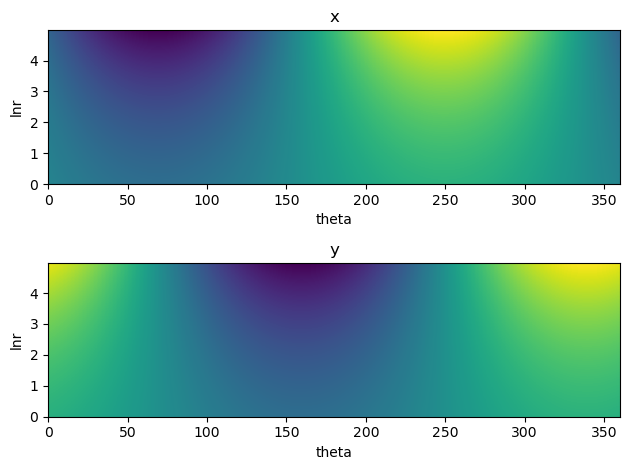

In [18]:
fig, ax = plt.subplots(2)
ax[0].imshow(x, extent=(0, theta_max, 0, lnr_max), origin='lower', aspect='auto')
ax[1].imshow(y, extent=(0, theta_max, 0, lnr_max), origin='lower', aspect='auto')
ax[0].set_title('x')
ax[1].set_title('y');
for a in ax:
    a.set_xlabel('theta')
    a.set_ylabel('lnr');
plt.tight_layout()

In [19]:
img_interp = RegularGridInterpolator((np.arange(img.shape[0]), np.arange(img.shape[1])), img)


In [20]:
ok = (x >= 0) & (x < img.shape[0] - 1) 
ok &= (y >= 0) & (y < img.shape[1] - 1) 


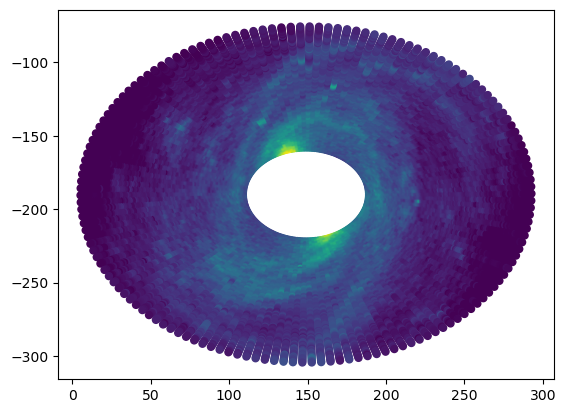

In [21]:
plt.scatter(y[ok], -x[ok], c=img_interp((x[ok], y[ok])),
            vmin=1000, vmax=1200, s=25);

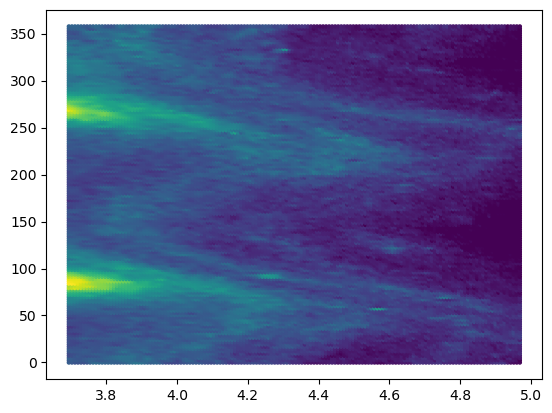

In [22]:
plt.scatter(lnr[ok], theta[ok], c=img_interp((x[ok], y[ok])),
            vmin=1000, vmax=1200, s=5);

In [23]:
print(x.shape,y.shape)

img_lnr_theta = img_interp((x, y))

(150, 150) (150, 150)


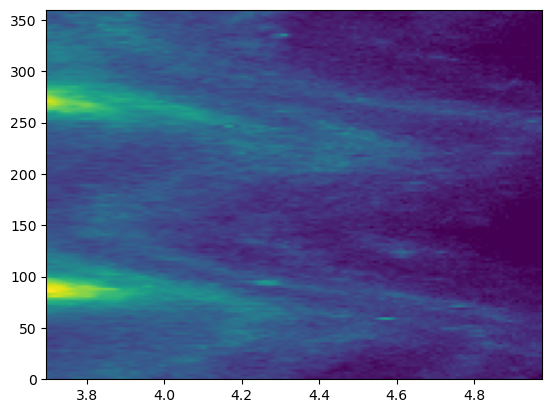

In [24]:
plt.imshow(img_lnr_theta.T, vmin=1000, vmax=1200,
           extent=(lnr_min, lnr_max, 0, theta_max),
           origin='lower', aspect='auto');

In [25]:

# use broadcasting to do multiple p at once
p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
m = 2
weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
D = img_lnr_theta.sum()
A = abs((img_lnr_theta * weight).sum((-1, -2)))
p_max = p.ravel()[A.argmax()]

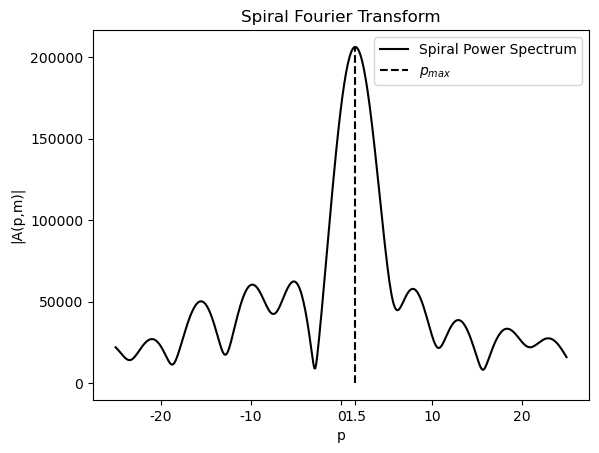

In [26]:
plt.figure()
plt.plot(p.ravel(), A,'k')
plt.vlines(p_max,0,np.max(A),'k','dashed','$p_(max)$')
plt.legend(['Spiral Power Spectrum','$p_{max}$'])
plt.title('Spiral Fourier Transform')
plt.xlabel('p')
plt.xticks([-20,-10,p_max,0,10,20],['-20','-10','{}'.format(np.around(p_max,1)),'0','10','20'])
plt.ylabel('|A(p,m)|');

In [27]:
p_max = p.ravel()[A.argmax()]
phi = np.degrees(np.arctan(-m/p_max))
print('Winding angle \u03C6 =', phi)

Winding angle φ = -53.130102354149074


In [28]:
# Combine into function

def Spiral_Fourier_Transform(Image,Table):
    img = Image
    Tab = Table
    # First collect image info from Table
    x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
    y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
    R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
    log_R_e = np.asarray(Tab['log_re']) # log effective radius
    log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*0.5) # log half effective radius
    pa = np.asarray(Tab['theta']) # position angle
    q = np.asarray(Tab['q']) # axis ratio
    
    
    # Get the dimensions of the Image
    height, width = img.shape[:2]   

    # Calculate the maximum possible radius
    max_radius = min(x0, y0, width-x0, height-y0)
    max_R = max_radius -1
    
    # Create x and y index arrays
    y, x = np.indices(img.shape)
    
    # Center index arrays
    x -= x0
    y -= y0
    
    # Deprojecting x,y by a series of affine transformations

    # Rotate by minus position angle
    ct = np.cos(-pa)
    st = np.sin(-pa)

    # Stretch according to axis ratio and rotation
    xp = (y * ct + x * st) / q
    yp = (-y * st + x * ct)

    # Convert to Polar
    rp2 = xp ** 2 +  yp ** 2
    rp = np.sqrt(rp2)
    tp = np.arctan2(yp, xp)
    
    # Define ln(r),theta image dimensions
    n_lnr = 150
    n_theta = 150
    
    # Create index arrays
    lnr, theta = np.indices((n_lnr, n_theta))
    
    # Define bounds for image dimensions
    lnr_min = float(log_R_e_05)
    lnr_max = float(np.log(int(max_R) -1))
    theta_max = 360
    lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
    theta = theta * theta_max / n_theta
    
    # Define xp and yp in terms of new coord system
    xp = np.exp(lnr) * np.sin(np.radians(theta))
    yp = np.exp(lnr) * np.cos(np.radians(theta))
    
    # this is an attempt at using the above deprojection code
    # to do the inverse by pa -> -pa and q -> 1/q   
    ct = np.cos(pa)
    st = np.sin(pa)
    x = (yp * ct + xp * st) * q
    y = (-yp * st + xp * ct)
    x += y0
    y += x0
    
    # Create a Regular grid from interpolation
    img_interp = RegularGridInterpolator((np.arange(img.shape[0]),
                                          np.arange(img.shape[1])), img)
    
    # Define allowed indices
    ok = (x >= 0) & (x < img.shape[0] - 1) 
    ok &= (y >= 0) & (y < img.shape[1] - 1) 
    
    # Create image from interpolation
    img_lnr_theta = img_interp((x, y))
    
    # Use broadcasting to do multiple p at once
    p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
    m = 2
    weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
    D = img_lnr_theta.sum()
    A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))
    
    # Calculate winding angle from maximum of Spiral Power spectrum
    p_max = p.ravel()[A.argmax()]
    phi = np.degrees(np.arctan(-m/p_max))
    print('Winding angle \u03C6 =', phi)
    
    return phi
        

In [29]:
phi = Spiral_Fourier_Transform(img,Tab)
phi

Winding angle φ = -53.130102354149074


-53.130102354149074

In [30]:
# now try with a different image:

tes_im = gfits.Read('/home/borge/Data/Test_batch/587736584426094619ra.fits.gz')
tes_tab = gfits.Read_Table('/home/borge/Data/Output_Data/Distributed_run/587736584426094619ra/0200/source_params.fits')
phi = Spiral_Fourier_Transform(tes_im,tes_tab)


Winding angle φ = -70.70995378080195


In [31]:
# Cool so working! - now will add options to display figures and options to save

# Combine into function

def Spiral_Fourier_Transform(Image,Table,R_min_multiple,m,plot,save):
    img = Image
    Tab = Table
    # First collect image info from Table
    x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
    y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
    R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
    log_R_e = np.asarray(Tab['log_re']) # log effective radius
    log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*R_min_multiple) # log half effective radius
    pa = np.asarray(Tab['theta']) # position angle
    q = np.asarray(Tab['q']) # axis ratio
    
    
    # Get the dimensions of the Image
    height, width = img.shape[:2]   

    # Calculate the maximum possible radius
    max_radius = min(x0, y0, width-x0, height-y0)
    max_R = max_radius -1
    
    # Create x and y index arrays
    y, x = np.indices(img.shape)
    
    # Center index arrays
    x -= x0
    y -= y0
    
    # Deprojecting x,y by a series of affine transformations

    # Rotate by minus position angle
    ct = np.cos(-pa)
    st = np.sin(-pa)

    # Stretch according to axis ratio and rotation
    xp = (y * ct + x * st) / q
    yp = (-y * st + x * ct)

    # Convert to Polar
    rp2 = xp ** 2 +  yp ** 2
    rp = np.sqrt(rp2)
    tp = np.arctan2(yp, xp)
    
    # Define ln(r),theta image dimensions
    n_lnr = 150
    n_theta = 150
    
    # Create index arrays
    lnr, theta = np.indices((n_lnr, n_theta))
    
    # Define bounds for image dimensions
    lnr_min = float(log_R_e_05)
    lnr_max = float(np.log(int(max_R) -1))
    theta_max = 360
    lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
    theta = theta * theta_max / n_theta
    
    # Define xp and yp in terms of new coord system
    xp = np.exp(lnr) * np.sin(np.radians(theta))
    yp = np.exp(lnr) * np.cos(np.radians(theta))
    
    # this is an attempt at using the above deprojection code
    # to do the inverse by pa -> -pa and q -> 1/q   
    ct = np.cos(pa)
    st = np.sin(pa)
    x = (yp * ct + xp * st) * q
    y = (-yp * st + xp * ct)
    x += y0
    y += x0
    
    # Create a Regular grid from interpolation
    img_interp = RegularGridInterpolator((np.arange(img.shape[0]),
                                          np.arange(img.shape[1])), img)
    
    # Define allowed indices
    ok = (x >= 0) & (x < img.shape[0] - 1) 
    ok &= (y >= 0) & (y < img.shape[1] - 1) 
    
    # Create image from interpolation
    img_lnr_theta = img_interp((x, y))
    
    # Use broadcasting to do multiple p at once
    p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
    weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
    D = img_lnr_theta.sum()
    A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))
    
    # Calculate winding angle from maximum of Spiral Power spectrum
    p_max = p.ravel()[A.argmax()]
    phi = np.degrees(np.arctan(-m/p_max))
    print('Winding angle \u03C6 =', phi)
    
    if plot == True:
        
        # Spiral Power Spectrum
        plt.figure()
        plt.plot(p.ravel(), A,'k')
        plt.vlines(p_max,0,np.max(A),'k','dashed','$p_(max)$')
        plt.legend(['Spiral Power Spectrum ','$p_{max}$'],loc='upper left')
        plt.title('Spiral Fourier Transform (m = {})'.format(m))
        plt.xlabel('p')
        plt.xticks([-20,-10,p_max,0,10,20],['-20','-10','{}'.format(np.around(p_max,1)),'0','10','20'])
        plt.ylabel('|A(p,m)|');
        if save == True:
            plt.savefig('Power Spectrum.png')
        
        # ln(r) theta image
        plt.figure()
        plt.imshow(img_lnr_theta.T, vmin=1000, vmax=1200,
           extent=(lnr_min, lnr_max, 0, theta_max),
           origin='lower', aspect='auto');
        plt.xlabel('\u03B8 (radians)')
        plt.ylabel('log(R)')
        if save == True:
            plt.savefig('log(R) Theta image.png')
        
        # Labeled galaxy Image
        fig, ax = plt.subplots()
        ax.imshow(img,vmin=1000,vmax=1200)

        # Define circle
        R_e_1 = Circle((x0,y0),R_e,edgecolor='black', facecolor=None, fill=False)
        R_e_05 = Circle((x0,y0),R_min_multiple*R_e,edgecolor='red', facecolor=None, fill=False)
        ax.plot(x0,y0,'xk')
        ax.add_patch(R_e_1)
        ax.add_patch(R_e_05)
        ax.legend(['center','$R_e$','${}\, R_e$'.format(R_min_multiple)])
        ax.axis('off')
        if save == True:
            plt.savefig('Labelled R_e image.png')
        
        return phi
    
    else:
        return phi
        

Winding angle φ = -46.468800714380066


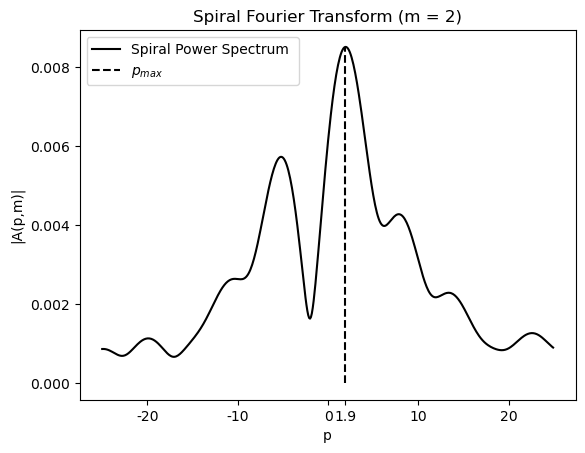

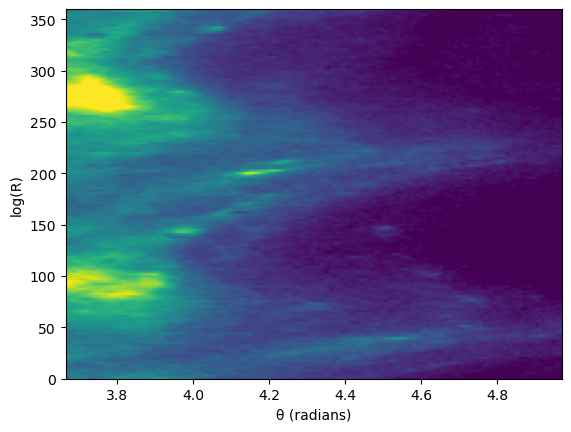

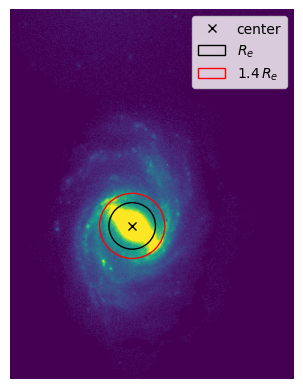

In [32]:
phi = Spiral_Fourier_Transform(tes_im,tes_tab,1.4,2,True,False)

In [33]:
# Use broadcasting to do multiple p at once
p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
D = img_lnr_theta.sum()
A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))

print(p.shape)
print(weight.shape)
print(D.dtype)
print(A.shape)

(500, 1, 1)
(500, 150, 150)
float64
(500,)


In [34]:
# Nice so now want to create a function which gives A(p,m)


def Spiral_power_spec(Image,Table,R_min_multiple,m):
    img = Image
    Tab = Table
    # First collect image info from Table
    x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
    y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
    R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
    log_R_e = np.asarray(Tab['log_re']) # log effective radius
    log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*R_min_multiple) # log half effective radius
    pa = np.asarray(Tab['theta']) # position angle
    q = np.asarray(Tab['q']) # axis ratio
    
    
    # Get the dimensions of the Image
    height, width = img.shape[:2]   

    # Calculate the maximum possible radius
    max_radius = min(x0, y0, width-x0, height-y0)
    max_R = max_radius -1
    
    # Create x and y index arrays
    y, x = np.indices(img.shape)
    
    # Center index arrays
    x -= x0
    y -= y0
    
    # Deprojecting x,y by a series of affine transformations

    # Rotate by minus position angle
    ct = np.cos(-pa)
    st = np.sin(-pa)

    # Stretch according to axis ratio and rotation
    xp = (y * ct + x * st) / q
    yp = (-y * st + x * ct)

    # Convert to Polar
    rp2 = xp ** 2 +  yp ** 2
    rp = np.sqrt(rp2)
    tp = np.arctan2(yp, xp)
    
    # Define ln(r),theta image dimensions
    n_lnr = 150
    n_theta = 150
    
    # Create index arrays
    lnr, theta = np.indices((n_lnr, n_theta))
    
    # Define bounds for image dimensions
    lnr_min = float(log_R_e_05)
    lnr_max = float(np.log(int(max_R) -1))
    theta_max = 360
    lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
    theta = theta * theta_max / n_theta
    
    # Define xp and yp in terms of new coord system
    xp = np.exp(lnr) * np.sin(np.radians(theta))
    yp = np.exp(lnr) * np.cos(np.radians(theta))
    
    # this is an attempt at using the above deprojection code
    # to do the inverse by pa -> -pa and q -> 1/q   
    ct = np.cos(pa)
    st = np.sin(pa)
    x = (yp * ct + xp * st) * q
    y = (-yp * st + xp * ct)
    x += y0
    y += x0
    
    # Create a Regular grid from interpolation
    img_interp = RegularGridInterpolator((np.arange(img.shape[0]),
                                          np.arange(img.shape[1])), img)
    
    # Define allowed indices
    ok = (x >= 0) & (x < img.shape[0] - 1) 
    ok &= (y >= 0) & (y < img.shape[1] - 1) 
    
    # Create image from interpolation
    img_lnr_theta = img_interp((x, y))
    
    # Use broadcasting to do multiple p at once
    p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
    weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
    D = img_lnr_theta.sum()
    A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))
    
    # Calculate winding angle from maximum of Spiral Power spectrum
    p_max = p.ravel()[A.argmax()]
    phi = np.degrees(np.arctan((0-m)/p_max)) #for some reason, Python was seeing "-m" and interepreting as a boolean function
    #print('Winding angle \u03C6 =', phi)
    
    return A, p, p_max, phi 


        

In [35]:
m = np.arange(0,5,1) + 1
m

array([1, 2, 3, 4, 5])

In [36]:
A_arr = np.empty((len(A),len(m)))
m_arr = np.empty_like(m).astype(float)

for i in range(0,len(m)):
    A, p, p_max, phi = Spiral_power_spec(tes_im,tes_tab,1.4,m[i])
    m_arr[i] = np.max(A)
    A_arr[:,i] = A
    print(np.max(A))
print('gax_fits: Number of arms: ',np.argmax(m_arr))
print(np.max(A_arr))

m_arr

0.0023233534697865233
0.008504615349115823
0.000711581187895742
0.0032363784532212516
0.0007237759558404833
gax_fits: Number of arms:  1
0.008504615349115823


array([0.00232335, 0.00850462, 0.00071158, 0.00323638, 0.00072378])

In [37]:

# Cool so making this into a function
def Number_of_arms(Image,Table,R_e_multiple):

    # Initialise empty arrays
    m_arr = np.empty_like(m).astype(float)

    # Create Loop
    for i in range(0,len(m)):
        A, p, p_max, phi = Spiral_power_spec(Image,Table,R_e_multiple,m[i])
        m_arr[i] = np.max(A) # find maximum
        A_arr[:,i] = A
        
    print('SFT: Number of arms: ',m[np.argmax(m_arr)])
    #print(m_arr)

    return m[np.argmax(m_arr)]

# Would be cool to be able to estimate the certainty using the std of the m-arr

n = Number_of_arms(tes_im,tes_tab,1.4)

SFT: Number of arms:  2


SFT: Number of arms:  2
Winding angle φ = -46.468800714380066


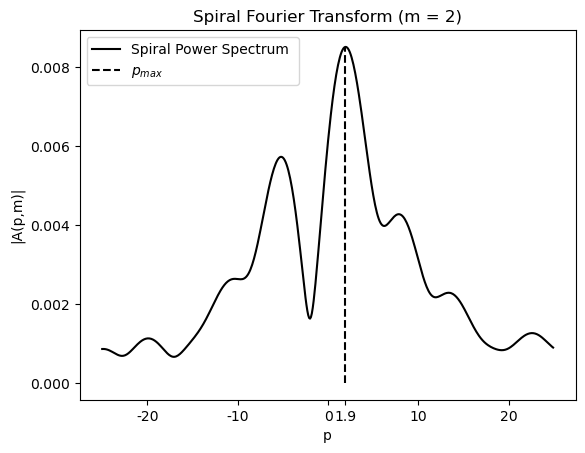

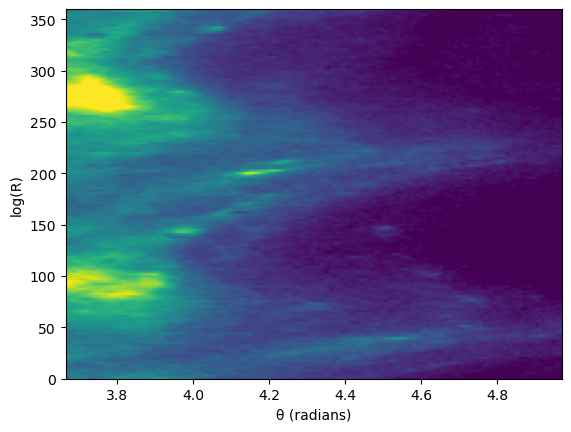

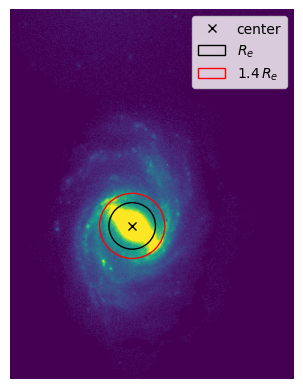

In [38]:
# fookin around 

phi = Spiral_Fourier_Transform(tes_im,tes_tab,1.4, Number_of_arms(tes_im,tes_tab,1.4),True,False)

Winding angle φ = -14.743562836469874


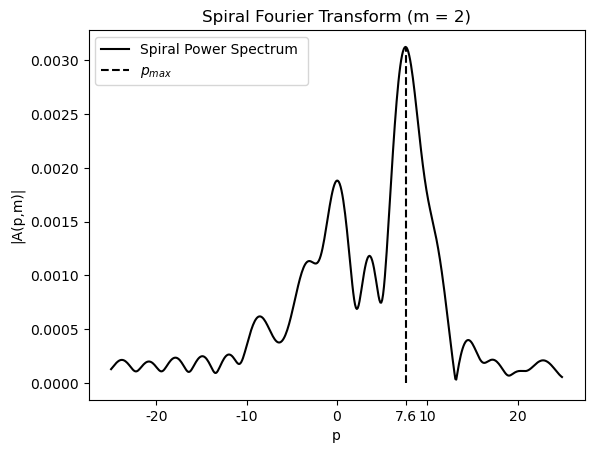

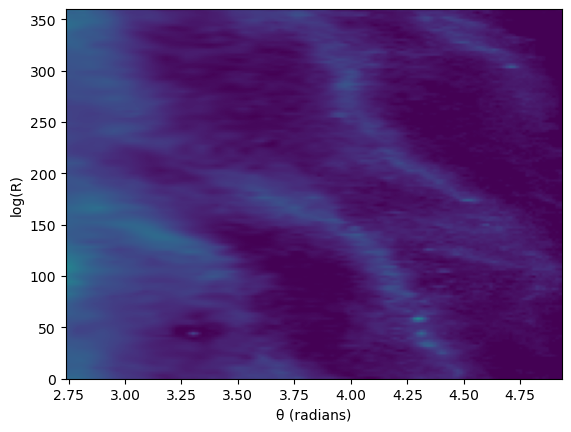

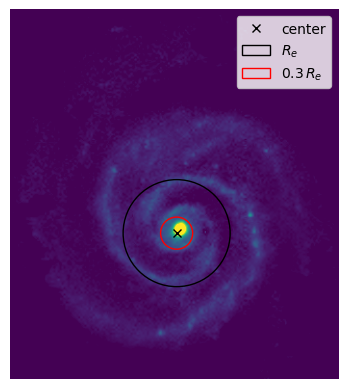

In [39]:
# Now will test on an isolated and non-isolated images to look at the difference

iso_im = gfits.Read('/home/borge/Data/Output_Data/Distributed_run/587732050555961424ra/0200/small_nonpar.fits') + 1000
org_im = gfits.Read('/home/borge/Data/Test_batch/587732050555961424ra.fits.gz')
source_table = gfits.Read_Table('/home/borge/Data/Output_Data/Distributed_run/587732050555961424ra/0200/source_params.fits')

phi_iso = Spiral_Fourier_Transform(iso_im,source_table,0.3,2,True,False)


Winding angle φ = -14.743562836469874


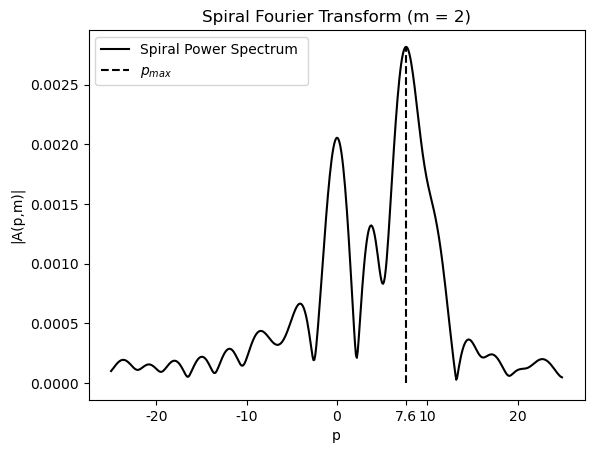

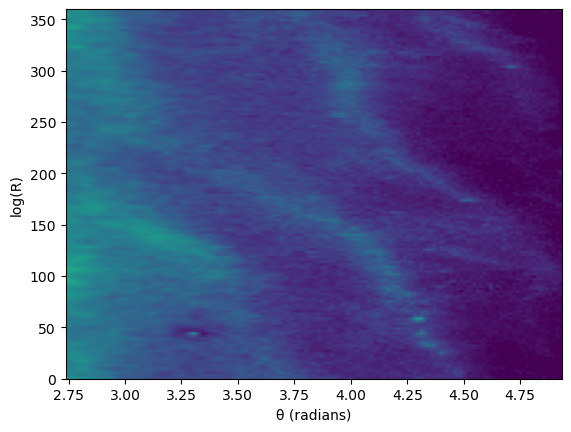

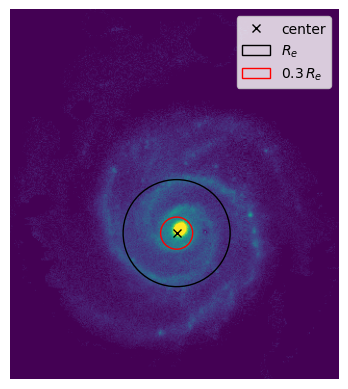

In [40]:
phi_org =Spiral_Fourier_Transform(org_im,source_table,0.3,2,True,False)

(-0.5, 315.5, 355.5, -0.5)

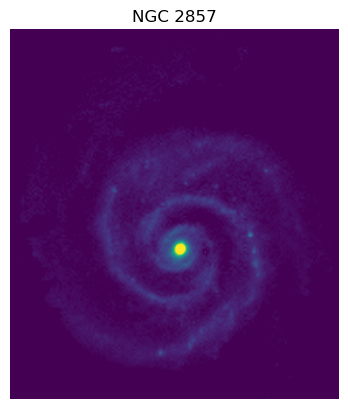

In [41]:
plt.imshow(iso_im,vmin=1000,vmax=1250)
plt.title('NGC 2857')
plt.axis('off')

(1, 1) [160]
(1, 1) [160]
Winding angle φ = -14.743562836469874  Pattern position angle θ =  10.78217348814537


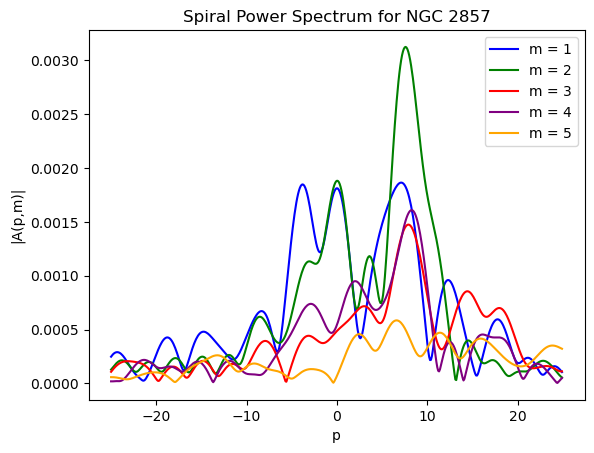

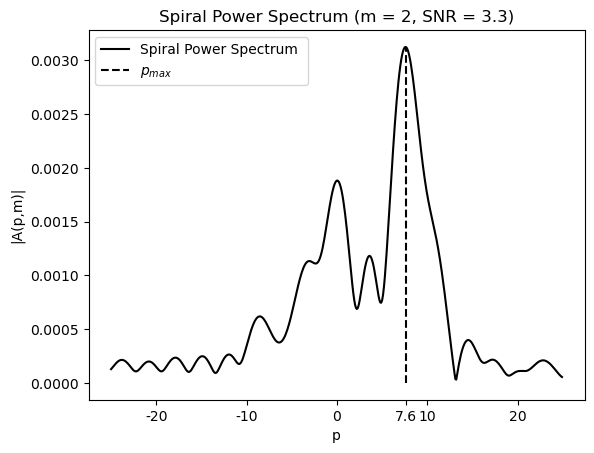

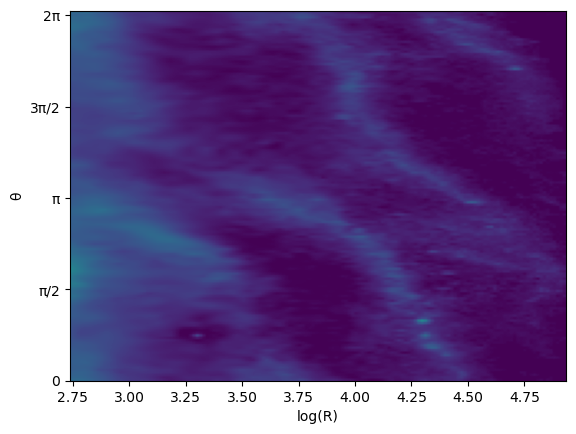

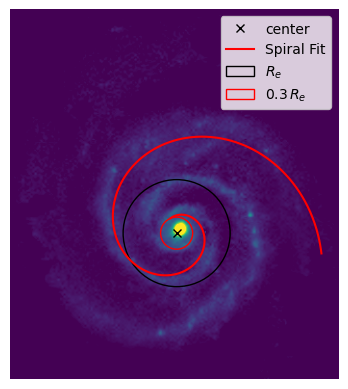

In [42]:
phi = gfits.Spiral_Fourier_Transform(iso_im,source_table,0.3,gfits.Number_of_arms(iso_im,source_table,0.3,True,False,objid='NGC 2857'),True,False)



In [43]:
# Want a function that works out distance in kpc/m
# display on R

# In order to determine real size we need distance and angular size/extent

# First require searching catalogue for ID

catalogue = gfits.Read_Table('/home/borge/Data/gz2and1master.fits.gz')




In [44]:
candidate_catalogue_info = catalogue['OBJID']
candidate_catalogue_info = catalogue[np.where((catalogue['OBJID'] == 587732050555961424))[0]]

candidate_catalogue_info

# that took ages lol make into a function

def catalogue_search(catalogue,Int_ID):
    candidate_catalogue_info = catalogue['OBJID']
    candidate_catalogue_info = catalogue[np.where((catalogue['OBJID'] == Int_ID))[0]]
    return candidate_catalogue_info

In [45]:
candidate = catalogue_search(catalogue,587732050555961424)
candidate = np.asarray(candidate)
candidate

array([(587732050555961424, '587732050555961424  ', 2863, 40, 5, 128, 80, 141.15719604, 49.35706329, 23.863445, 41.75981, 24.607925, 13.869946, 13.17813, 13.025054, 13.218521, 69.58197, 0.00450768, 0.00253353, 0.00563471, 0.01754806, 17.631317, 17.502186, 13.462911, 0.0021056, 13.241689, 0.00207609, 0.47247458, 22.06224632, 0.11550888, 0.08499033, 0.06164208, 0.04674132, 0.03314018, 947.75714, 338.12543, 953.3693, 338.15436, 943.6345, 339.5624, 947.23663, 340.7297, 952.00415, 338.2578, 13.34062386, 0.00149309, 0.0163121, 0.00015864, -8.243244, -20.5035, -21.141071, -21.27492, -21.038536, 99999., 0.01096901, 0.01031595, 0.01147824, 0.02019739, 7.9233904, 6, 79, 57, 0, 0, 'original        ', 50188, 354, 349.7, 0., 0., 44.14, 1., 0., 0., 44.14, 2.14, 0.048, 42., 0.952, 44.14, 3., 0.071, 39., 0.929, 42., 42., 1., 0., 0., 42., 1., 0.024, 35., 0.833, 6., 0.143, 0., 0., 42., 5.14, 0.116, 39., 0.884, 44.14, 0., 0., 0., 0., 0., 0., 0., 5.14, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5

In [46]:
# get redshift and angular size
# have to ask steven if this is okay it says that petrosian is basically r band and less sensitive reddening

z =  candidate['REDSHIFT']
R_e_KPC = candidate['PETROR50_R_KPC']
pix_KPC_factor = R_e_KPC/R_e
print(z,theta,R_e,pix_KPC_factor )

def pix_to_KPC(candidate):
    R_e_KPC = candidate['PETROR50_R_KPC']
    R_e_pix = candidate['PETROR50_R_KPC_SIMPLE_BIN']
    pix_KPC_factor = R_e_KPC/R_e_pix
    return pix_KPC_factor




[0.0163121] [[  0.    2.4   4.8 ... 352.8 355.2 357.6]
 [  0.    2.4   4.8 ... 352.8 355.2 357.6]
 [  0.    2.4   4.8 ... 352.8 355.2 357.6]
 ...
 [  0.    2.4   4.8 ... 352.8 355.2 357.6]
 [  0.    2.4   4.8 ... 352.8 355.2 357.6]
 [  0.    2.4   4.8 ... 352.8 355.2 357.6]] [80.49193542] [0.09843707]


356
Winding angle φ = -14.743562836469874
[2.73832904 3.28736527 3.83640149 4.38543771 4.93447393]


([<matplotlib.axis.YTick at 0x7fbabdaf7bb0>,
 [Text(0, 0, '2.7'),
  Text(0, 79, '3.3'),
  Text(0, 158, '3.8'),
  Text(0, 237, '4.4'),
  Text(0, 316, '4.9')])

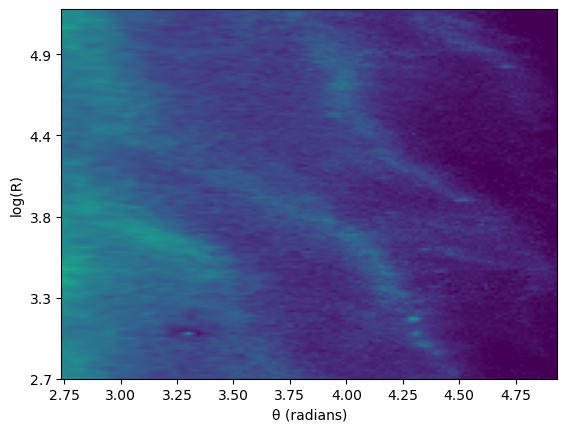

In [47]:
R_min_multiple = 0.3
m = 2
img = org_im
Tab = source_table
# First collect image info from Table
x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
log_R_e = np.asarray(Tab['log_re']) # log effective radius
log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*R_min_multiple) # log half effective radius
pa = np.asarray(Tab['theta']) # position angle
q = np.asarray(Tab['q']) # axis ratio


# Get the dimensions of the Image
height, width = img.shape[:2]   

# Calculate the maximum possible radius
max_radius = min(x0, y0, width-x0, height-y0)
max_R = max_radius -1

# create a spaced array for log KPC
KPC = pix_KPC_factor*np.linspace(0,height,4)

# Create x and y index arrays
y, x = np.indices(img.shape)

# Center index arrays
x -= x0
y -= y0

# Deprojecting x,y by a series of affine transformations

# Rotate by minus position angle
ct = np.cos(-pa)
st = np.sin(-pa)

# Stretch according to axis ratio and rotation
xp = (y * ct + x * st) / q
yp = (-y * st + x * ct)

# Convert to Polar
rp2 = xp ** 2 +  yp ** 2
rp = np.sqrt(rp2)
tp = np.arctan2(yp, xp)

# Define ln(r),theta image dimensions
n_lnr = 150
n_theta = 150

# Create index arrays
lnr, theta = np.indices((n_lnr, n_theta))

# Define bounds for image dimensions
lnr_min = float(log_R_e_05)
lnr_max = float(np.log(int(max_R) -1))
theta_max = 360
lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
theta = theta * theta_max / n_theta

# Define xp and yp in terms of new coord system
xp = np.exp(lnr) * np.sin(np.radians(theta))
yp = np.exp(lnr) * np.cos(np.radians(theta))

# this is an attempt at using the above deprojection code
# to do the inverse by pa -> -pa and q -> 1/q   
ct = np.cos(pa)
st = np.sin(pa)
x = (yp * ct + xp * st) * q
y = (-yp * st + xp * ct)
x += y0
y += x0

# Create a Regular grid from interpolation
img_interp = RegularGridInterpolator((np.arange(img.shape[0]),
                                        np.arange(img.shape[1])), img)

print(height)

# Define allowed indices
ok = (x >= 0) & (x < img.shape[0] - 1) 
ok &= (y >= 0) & (y < img.shape[1] - 1) 

# Create image from interpolation
img_lnr_theta = img_interp((x, y))

# Use broadcasting to do multiple p at once
p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
D = img_lnr_theta.sum()
A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))

# Calculate winding angle from maximum of Spiral Power spectrum
p_max = p.ravel()[A.argmax()]
phi = np.degrees(np.arctan(-m/p_max))
print('Winding angle \u03C6 =', phi)

# ln(r) theta image
plt.figure()
plt.imshow(img_lnr_theta.T, vmin=1000, vmax=1200,
    extent=(lnr_min, lnr_max, 0, theta_max),
    origin='lower', aspect='auto');
plt.xlabel('\u03B8 (radians)')
plt.ylabel('log(R)')
lnr_y_axis = np.linspace(lnr_min,lnr_max,5)
print(lnr_y_axis)
#lnr_height = int(lnr_y_axis*height)
#print(height)
plt.yticks([0,int(img.shape[1]/4),int(img.shape[1]/2),int(((img.shape[1]+1)*3)/4),img.shape[1]],np.around(lnr_y_axis,1))


In [48]:
# Start plotting spirals:

# First in polar using log spiral equation
r_0 = 1 # need a better way of scaling the spiral
theta = np.linspace(2*np.pi,8*(np.pi),3600)
phi = -14.743562836469874
r = r_0 *np.exp(theta*np.abs(np.tan(np.radians(phi)))) # 
r


array([  5.22507848,   5.23228504,   5.23950153, ..., 743.31708885,
       744.34229008, 745.3689053 ])

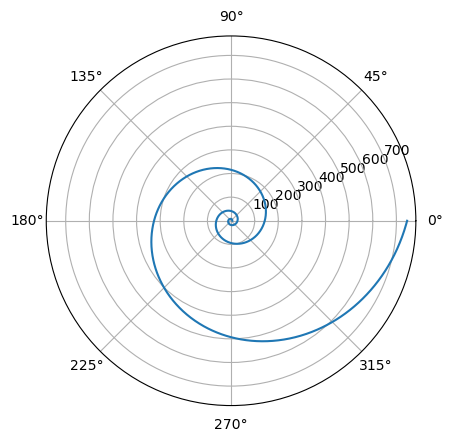

In [49]:
plt.polar(theta,r)

In [50]:
# Now need to convert these to cartesian to plot ontop of image
x = r*np.cos(theta)
y = r*np.sin(theta)
print(len(x),len(y))

3600 3600


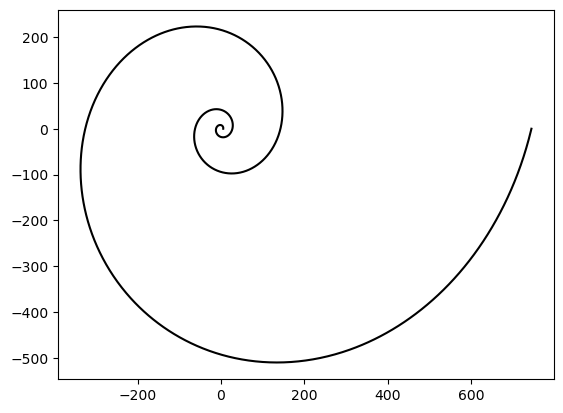

In [51]:
plt.figure()
plt.plot(x,y,'k')
plt.show()
# okay so got it but it kind of looks different but it might be scale

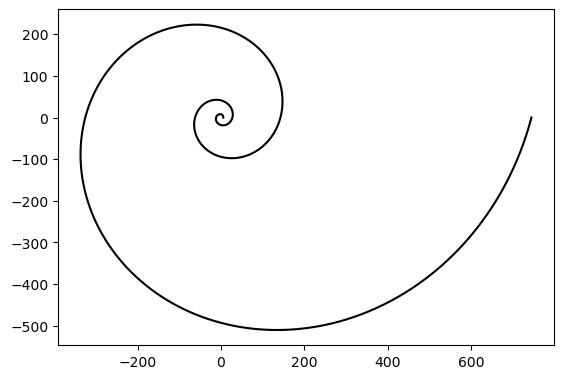

In [52]:
fig, ax = plt.subplots()

ax.plot(x,y,'k')
ax.set_aspect(1)

# Better

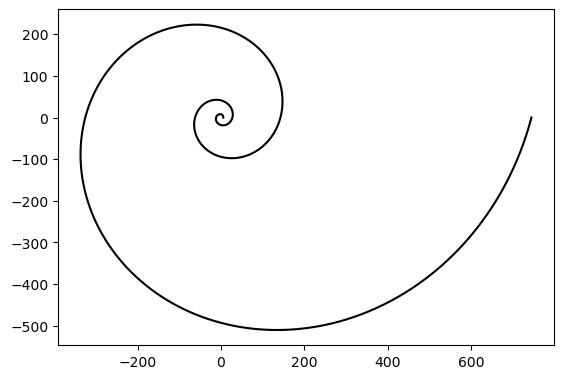

In [53]:
# now need a function that will rotate the spiral

# set rotation ammount
A = 0
theta = A*np.pi/4
rot_mat = np.array([[np.cos(theta),-np.sin(theta)],
                   [np.sin(theta), np.cos(theta)]])

# need to make x,y into a vector
vector = np.stack([x,y],axis=1).T
#print(vector)

rotated_vector = rot_mat @ vector

fig, ax = plt.subplots()

ax.plot(rotated_vector[0],rotated_vector[1],'k')
ax.set_aspect(1)



(0.0, 356.0)

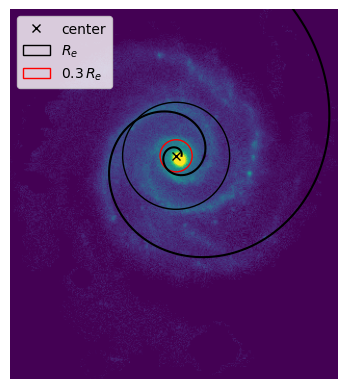

In [54]:
# Labeled galaxy Image
fig, ax = plt.subplots()
ax.imshow(img,vmin=1000,vmax=1200)

# Define circle
R_e_1 = Circle((x0,y0),R_e,edgecolor='black', facecolor=None, fill=False)
R_e_05 = Circle((x0,y0),R_min_multiple*R_e,edgecolor='red', facecolor=None, fill=False)
ax.plot(x0,y0,'xk')
ax.add_patch(R_e_1)
ax.add_patch(R_e_05)
ax.legend(['center','$R_e$','${}\, R_e$'.format(R_min_multiple)])
ax.axis('off')
ax.plot(rotated_vector[0]+x0[0],rotated_vector[1]+y0[0],'k')
ax.set_xlim(0,img.shape[1])
ax.set_ylim(0,img.shape[0])

3600 3600


(0.0, 356.0)

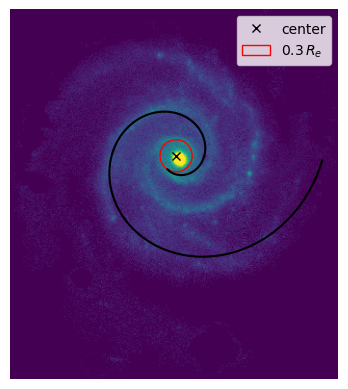

In [55]:
# Now need to make a function which exports the x and y points of the spiral for plotting given the Spiral information

# Get some information to work with
A, A_p_m, p, SN_w, p_max, SN_m, phi = gfits.Spiral_power_spec(tes_im,tes_tab,1.4,2)


# Create Polar Spiral
p_max = p_max
A_p_max = A_p_m[np.argmax(A_p_m)]
argument = np.angle(A_p_max)
r_0 = 1                                     # Scale 1:1 pix
theta = np.linspace(2*np.pi,8*(np.pi),3600)
phi = np.degrees(np.arctan(-m/p_max))
r = r_0 *np.exp(theta*np.abs(np.tan(np.radians(phi)))) 

# Convert to Cartesian

x = r*np.cos(theta)
y = r*np.sin(theta)
print(len(x),len(y))
# Rotate Spiral by argument of A(p_max,m)

theta = argument
rot_mat = np.array([[np.cos(theta),-np.sin(theta)],
                   [np.sin(theta), np.cos(theta)]])

rotated_vector = rot_mat @ vector

x_ = rotated_vector[0] 
y_ = rotated_vector[1] 

# Labeled galaxy Image
fig, ax = plt.subplots()
ax.imshow(img,vmin=1000,vmax=1200)
height, width = img.shape[:2]   

# Define circle
R_e_1 = Circle((x0,y0),R_e,edgecolor='black', facecolor=None, fill=False)
R_e_05 = Circle((x0,y0),R_min_multiple*R_e,edgecolor='red', facecolor=None, fill=False)

# Trim line plot so that it doesn't enter the unsampled area or outside the image
count_c = 0
count_e = 0 
for i in range(0,len(x_)):
    if np.sqrt(x_[i]**2 + (y_[i]**2)) <= R_min_multiple*R_e:
        count_c = count_c +  1
    elif  np.sqrt(x_[i]**2 + (y_[i]**2)) > min(x0, y0, width-x0, height-y0):
        count_e = count_e + 1
    else:
        continue
x_ = x_[count_c:len(x_)-count_e]
y_ = y_[count_c:len(y_)-count_e]

# Plotting
ax.plot(x0,y0,'xk')
#ax.add_patch(R_e_1)
ax.add_patch(R_e_05)
ax.legend(['center','${}\, R_e$'.format(R_min_multiple)]) # ,'$R_e$'
ax.axis('off')
ax.plot(x_+x0[0],y_+y0[0],'k')

ax.set_xlim(0,img.shape[1])
ax.set_ylim(0,img.shape[0])

In [56]:
# Okay so now assemble into a function
def gen_spiral(p_max,A_p_m,m,R_e,R_min_multiple,img):
    """
    Generates a polar spiral with the given parameters and returns its x and y coordinates.

    Args:
        p_max (float): The maximum power density of the spiral.
        A_p_m (numpy.ndarray): Array of complex amplitudes of the spiral.
        m (float): Constant that determines the rate of increase in pitch of the spiral.
        R_e (float): The radius of the spiral.
        R_min_multiple (float): Multiple of R_e that represents the minimum radius at which the spiral can be sampled.

    Returns:
        tuple: A tuple of two numpy arrays representing the x and y coordinates of the polar spiral.
    """
    # Get image info:
    height, width = img.shape[:2]   
    
    # Create Polar Spiral
    A_p_max = A_p_m[np.argmax(A_p_m)]
    argument = np.angle(A_p_max)
    
    # Sort A_p_m by abs
    A = np.abs(A_p_m)
    phi_arr = np.degrees(np.arctan(-m/p))
    sorted_A = np.argsort(A)
    top_20_frequencies = sorted_A[:20]
    A_top = A_p_m[top_20_frequencies]
    phi_top = phi_arr[top_20_frequencies]
    arguments = np.angle(A_top)
    arm_winding_angles = phi_top.ravel()[:m]
    arm_offset_angles = arguments[:m]
    print('offset= ',np.degrees(arm_offset_angles),'winding = ',np.degrees(arm_winding_angles))
    
    if m == 1:
        r_0 = 1                                     # Scale 1:1 pix
        theta = np.linspace(2*np.pi,8*(np.pi),3600)
        phi = np.degrees(np.arctan(-m/p_max))
        r = r_0 *np.exp(theta*np.abs(np.tan(arm_winding_angles[0])))
        
        # Convert to Polar to Cartesian
        x = r*np.cos(theta)
        y = r*np.sin(theta) 
        
        
        rot_mat = np.array([[np.cos(argument),-np.sin(argument)],
                        [np.sin(argument), np.cos(argument)]])

        rotated_vector = rot_mat @ vector

        x_ = rotated_vector[0] 
        y_ = rotated_vector[1] 
        
    # Trim line plot so that it doesn't enter the unsampled area or outside the image
        count_c = 0
        count_e = 0 
        for i in range(0,len(x_)):
            if np.sqrt(x_[i]**2 + (y_[i]**2)) <= R_min_multiple*R_e:
                count_c = count_c +  1
            elif  np.sqrt(x_[i]**2 + (y_[i]**2)) > min(x0, y0, width-x0, height-y0):
                count_e = count_e + 1
            else:
                continue
        x_ = x_[count_c:len(x_)-count_e]
        y_ = y_[count_c:len(y_)-count_e]

        
        return x_,y_
        
    elif m == 2:
        r_0 = 1                                     # Scale 1:1 pix
        theta = np.linspace(2*np.pi,8*(np.pi),3600)
        r_0 = r_0 *np.exp(theta*np.abs(np.tan(arm_winding_angles[0])))
        
        r_1 = 1                                     # Scale 1:1 pix
        theta = np.linspace(2*np.pi,8*(np.pi),3600)
        r_1 = r_1 *np.exp(theta*np.abs(np.tan(arm_winding_angles[1])))
    
        # Convert to Polar to Cartesian
        x_0 = r_0*np.cos(theta)
        y_0 = r_0*np.sin(theta) 
        vector_0 = np.stack([x_0,y_0],axis=1).T
        
        
        x_1 = r_1*np.cos(theta)
        y_1 = r_1*np.sin(theta) 
        vector_1 = np.stack([x_1,y_1],axis=1).T
        
        rot_mat_0 = np.array([[np.cos(arm_offset_angles[0]),-np.sin(arm_offset_angles[0])],
                        [np.sin(arm_offset_angles[0]), np.cos(arm_offset_angles[0])]])
        
        rot_mat_1 = np.array([[np.cos(arm_offset_angles[1]),-np.sin(arm_offset_angles[1])],
                        [np.sin(arm_offset_angles[1]), np.cos(arm_offset_angles[1])]])

        arm_0 = rot_mat_0 @ vector_0
        arm_1 = rot_mat_1 @ vector_1

        x_0_ = arm_0[0] 
        y_0_ = arm_0[1] 
        
        x_1_ = arm_1[0] 
        y_1_ = arm_1[1] 
            
        

        
        return x_0_,y_0_,x_1_,y_1_
        
        
    
    else:
        print('Too many arms!')    

    

offset=  [122.52959537 141.00866484] winding =  [382.21743357 384.44533031]
[1.09449019e+01 1.08998614e+01 1.08542443e+01 ... 5.80720732e+04
 5.78410588e+04 5.76070228e+04]


(0.0, 356.0)

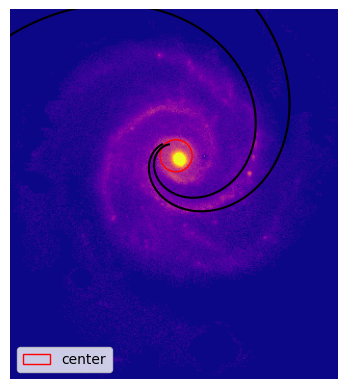

In [57]:
x_0,y_0,x_1,y_1 = gen_spiral(p_max,A_p_m,m,R_e,R_min_multiple,img)
print(y_1)
# Labeled galaxy Image
fig, ax = plt.subplots()
ax.imshow(img,cmap='plasma',vmin=1000,vmax=1200)
# Define circle
R_e_1 = Circle((x0,y0),R_e,edgecolor='black', facecolor=None, fill=False)
R_e_05 = Circle((x0,y0),R_min_multiple*R_e,edgecolor='red', facecolor=None, fill=False)

# Plotting
#ax.plot(x0,y0,'xk')
#ax.add_patch(R_e_1)
ax.add_patch(R_e_05)
ax.legend(['center','${}\, R_e$'.format(R_min_multiple)]) # ,'$R_e$'
ax.axis('off')
ax.plot(x_0+x0[0],y_0+y0[0],'k')
ax.plot(x_1+x0[0],y_1+y0[0],'k')
ax.set_xlim(0,img.shape[1])
ax.set_ylim(0,img.shape[0])

In [58]:
# This doesn't seem to be working very well so going to modify the function so that
# it outputs the top 20 dominant frequencies in A(p,m)

def Spiral_power_spec(Image,Table,R_min_multiple,m):
    """
    This function calculates the Spiral Power Spectrum of an input image based on a given table of galaxy properties.

    Parameters:
    Image (numpy array): Input image to be analyzed
    Table (astropy Table): Table containing galaxy properties including x, y, log_re, theta, and q
    R_min_multiple (float): Multiplicative factor for the effective radius to set the minimum radius for the Spiral Power Spectrum
    m (int): Integer value for the number of spiral arms to analyze

    Returns:
    A (numpy array): Spiral Power Spectrum values
    p (numpy array): Fourier mode values
    p_max (float): Fourier mode corresponding to the maximum Spiral Power Spectrum value
    phi (float): Winding angle of the spiral arms in degrees
    """
    img = Image
    Tab = Table
    # First collect image info from Table
    x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
    y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
    R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
    log_R_e = np.asarray(Tab['log_re']) # log effective radius
    log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*R_min_multiple) # log half effective radius
    pa = np.asarray(Tab['theta']) # position angle
    q = np.asarray(Tab['q']) # axis ratio
        
    # Get the dimensions of the Image
    height, width = img.shape[:2]   

    # Calculate the maximum possible radius
    max_radius = min(x0, y0, width-x0, height-y0)
    max_R = max_radius -1
    
    # Create x and y index arrays
    y, x = np.indices(img.shape)
    
    # Center index arrays
    x -= x0
    y -= y0
    
    # Deprojecting x,y by a series of affine transformations

    # Rotate by minus position angle
    ct = np.cos(-pa)
    st = np.sin(-pa)

    # Stretch according to axis ratio and rotation
    xp = (y * ct + x * st) / q
    yp = (-y * st + x * ct)

    # Convert to Polar
    rp2 = xp ** 2 +  yp ** 2
    rp = np.sqrt(rp2)
    tp = np.arctan2(yp, xp)
    
    # Define ln(r),theta image dimensions
    n_lnr = 150
    n_theta = 150
    
    # Create index arrays
    lnr, theta = np.indices((n_lnr, n_theta))
    
    # Define bounds for image dimensions
    lnr_min = float(log_R_e_05)
    lnr_max = float(np.log(int(max_R) -1))
    theta_max = 360
    lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
    theta = theta * theta_max / n_theta
    
    # Define xp and yp in terms of new coord system
    xp = np.exp(lnr) * np.sin(np.radians(theta))
    yp = np.exp(lnr) * np.cos(np.radians(theta))
    
    # this is an attempt at using the above deprojection code
    # to do the inverse by pa -> -pa and q -> 1/q   
    ct = np.cos(pa)
    st = np.sin(pa)
    x = (yp * ct + xp * st) * q
    y = (-yp * st + xp * ct)
    x += y0
    y += x0
    
    # Create a Regular grid from interpolation
    img_interp = RegularGridInterpolator((np.arange(img.shape[0]),
                                          np.arange(img.shape[1])), img)
    
    # Define allowed indices
    ok = (x >= 0) & (x < img.shape[0] - 1) 
    ok &= (y >= 0) & (y < img.shape[1] - 1) 
    
    # Create image from interpolation
    img_lnr_theta = img_interp((x, y))
    
    # Use broadcasting to do multiple p at once
    p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
    weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
    D = img_lnr_theta.sum()
    abs_A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))
    A =  1/D * (img_lnr_theta * weight).sum((-1, -2))
    # Calculate winding angle from maximum of Spiral Power spectrum
   
    p_max = p.ravel()[A.argmax()]
    phi = np.degrees(np.arctan((0-m)/p_max))
    phi_arr = np.degrees(np.arctan((0-m)/p))
    #print('Winding angle \u03C6 =', phi)
    
    return A, abs_A, p, p_max, phi, phi_arr 

In [59]:
A, abs_A, p, p_max, phi, phi_arr = Spiral_power_spec(tes_im,tes_tab,1.4,2)
A.shape


(500,)

In [60]:
sorted_A = np.argsort(abs_A)
top_20_frequencies = sorted_A[:20]
A_top = A[top_20_frequencies]
abs_A_top = abs_A[top_20_frequencies]
p_top = p[top_20_frequencies]
phi_top = phi_arr[top_20_frequencies]

In [61]:
sorted_A = np.argsort(A)
top_20_frequencies = sorted_A[:20]
A_top = A[top_20_frequencies]
abs_A_top = abs_A[top_20_frequencies]
p_top = p[top_20_frequencies]
phi_top = phi_arr[top_20_frequencies]
A_args_top = np.angle(A_top)
print(A_args_top)


[ 2.97880963 -2.88702259 -2.99399132  2.8836346   2.56088078 -2.47025552
 -2.9268474   2.92909714 -2.58960832  2.47696942 -3.05500495 -2.50053376
  2.81170816  2.50083691 -2.63769634  2.89769615 -3.0096598  -2.92028582
  2.96213961  2.14238314]


In [62]:
np.degrees(A_args_top) # The rotation of the arm is related to these angles

array([ 170.6732197 , -165.41420992, -171.54306676,  165.22009248,
        146.72766063, -141.53521556, -167.69600348,  167.82490364,
       -148.37362718,  141.91989365, -175.0388899 , -143.27003101,
        161.09901074,  143.28739996, -151.12886765,  166.02575971,
       -172.44080411, -167.32005266,  169.71809794,  122.74951219])

In [63]:
abs_A_top

array([0.00846854, 0.00849306, 0.0074509 , 0.00758898, 0.00843095,
       0.00850462, 0.0067868 , 0.00657961, 0.00730597, 0.00771954,
       0.00571767, 0.00698392, 0.005723  , 0.00636286, 0.0057018 ,
       0.00502402, 0.00488132, 0.00488167, 0.0047744 , 0.00838026])

In [64]:
phi_top.ravel()

array([-49.63546343, -48.0127875 , -31.21840276, -32.00538321,
       -51.34019175, -46.46880071, -81.46923439, -84.28940686,
       -30.46554492, -32.82854179,  21.41296947, -78.69006753,
        21.03751103, -87.13759477,  21.80140949, -22.61986495,
       -22.20347853,  16.85839877,  16.62075691, -53.13010235])

In [65]:
# High frequency filter from http://rb.gy/lit36t
G_p = np.exp(0.5*(p.ravel()-p_max/25)**2)
print(G_p.shape)

filtered_A = np.array([[G_p*A]]).T
#print(p.shape,lnr,filtered_A.shape)
filtered_A.shape

(500,)


(500, 1, 1)

In [66]:
weight = np.exp(1j*p*lnr)
weight.shape


(500, 150, 150)

In [67]:
S_u =  np.sum(filtered_A* weight,axis=0) * ((D)/(np.exp(2*lnr)*4*np.pi**2))

In [68]:
S_u.shape

(150, 150)

In [69]:
theta = np.linspace(0,2*np.pi,150)
theta.shape
m=2

In [70]:
S_u_theta = S_u*np.exp(1j*m*theta) # S_u*np.exp(1j*m*theta)

In [71]:
S_u_theta.shape

(150, 150)

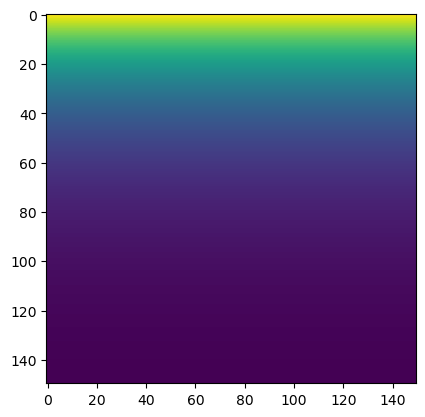

In [72]:
plt.imshow(abs(S_u_theta))
# This is not working 

In [73]:
# make it into a function none the less

def ISFT(A,p,p_max):
    
    # First create high frequency filter
    G_p = np.exp(0.5*(p.ravel()-p_max/25)**2)
    
    # Apply filter to A
    filtered_A = np.array([[G_p*A]]).T # attempting broadcasting
    
    # create weights for IFT
    weight = np.exp(1j*p*lnr)
    
    # Integrate
    S_u =  np.sum(filtered_A* weight,axis=0) * ((D)/(np.exp(2*lnr)*4*np.pi**2))
    
    # Create array of theta
    theta = np.linspace(0,2*np.pi,S_u.shape[0])
    
    # Sum over fourier components
    S_u_theta = S_u*np.exp(1j*m*theta) # there is no sum here...? what is going on
    
    return np.real(S_u_theta) # this is meant to be an image array but its complex (hence real)
    

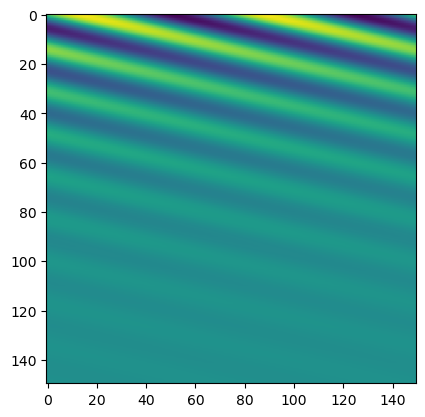

In [74]:
ISFT_img = ISFT(A,p,p_max)
plt.imshow(ISFT_img)

In [75]:
# Calculate signal to noise according to - working book formulas taken from - Creating Spiral Fourier Transfrom

# get average of power spectrum
L = np.average(np.abs(A))

# Calculate rms estimate of the spectrum
sigma = np.sqrt(np.average((np.abs(A)-L)**2))

# Calculate signal to noise using sigma and L
SN = (np.abs(A[np.argmax(np.abs(A))])-L)/sigma 
SN

2.777171690832104

In [76]:
# check that is the maximum of the spectrum
np.abs(A[np.argmax(np.abs(A))])

0.008504615349115823

In [77]:
# Cool so now make into a function that can go into the power spec function

def SN(A):
    
    # get average of power spectrum
    L = np.average(np.abs(A))
    # Calculate rms estimate of the spectrum
    sigma = np.sqrt(np.average((np.abs(A)-L)**2))

    # Calculate signal to noise of global maxima using sigma and L
    SN_max = (np.abs(A[np.argmax(np.abs(A))])-L)/sigma 
    
    # Calculate signal to noise of all values to provide a weighting list
    SN_weightings = (np.abs(A)-L)/sigma 
    
    return SN_max, SN_weightings

In [78]:
SN_m, SN_w = SN(A)
print(SN_m,SN_w.shape)
# Nice so now want to use this to select the 20 components which have the heighest S/N


2.777171690832104 (500,)


In [79]:
sorted_weights = np.argsort(SN_w)
top_20_frequencies = sorted_weights[:20]
dominant_signals = sorted_weights[top_20_frequencies]
dominant_signals # indices for the dominant signals in A(p,m) according to SN

# This can be ISFT onto the image  

# This could be adapted to look over all m and could help with splitting/children arms


array([ 35, 432, 433, 451, 450, 499,  92,  66,  27,  85,  16,  17,  73,
        67,  74,  86, 431,  26,  28, 434])

In [80]:
# Implemented into spiral power spec: 
A, A_p_m, p, SN_w, p_max, SN_m, phi = gfits.Spiral_power_spec(tes_im,tes_tab,1.4,2)
dominant_mode = gfits.Number_of_arms(tes_im,tes_tab,1.4,False,False)

In [81]:
P = np.abs(A) # Spiral Power spectrum
L = np.mean(P) # Average Power

m_arr = np.arange(0,5,1) + 1 # Harmonic modes

A_arr = np.empty((len(A),len(m_arr)),dtype=complex) # Array of SFT's
SN_w_arr = np.empty((len(A),len(m_arr))) # stacked array of weights
SN_m_arr = np.empty((len(A),len(m_arr))) # Array of global max SN
p_max_arr = np.empty_like(m_arr) # Array of p_max
phi_arr = np.empty_like(m_arr) # Array of corresponding phi
L_arr = np.empty_like(m_arr)

print(A_arr[:,4].shape)

(500,)


In [82]:

for i in range(0,len(m_arr)):
    A, A_p_m, p, SN_w, p_max, SN_m, phi_arr[i] = gfits.Spiral_power_spec(tes_im,tes_tab,1.4,m_arr[i])
    A_arr[:,i] = A
    L_arr[i] = np.mean(np.abs(A))
    SN_w_arr[:,i] = SN_w
    p_max_arr[i] = p_max
    SN_m_arr[i] = SN_m
    phi_arr[i] = phi
    print(A[0])


0.0006681325710134556
0.0008585983010157044
0.00017333253860203607
0.00017192349546547357
0.00010081651247787828


In [83]:
# Now want to measure the flattness of the power spectra
# and also the prak intensities in terms of the largest

# Measure the flatness of each spectra using the 
# spectral flatness measure

from scipy.stats import gmean

def SFM(spectrum):
    """
    Calculates the spectral flatness measure (SFM) of a given spectrum.

    The SFM is defined as the ratio of the geometric mean to the arithmetic mean of the spectrum.

    Args:
    - spectrum (ndarray): 1-D array containing the power spectrum of a signal.

    Returns:
    - SFM (float): the spectral flatness measure of the input spectrum.
    """
    arithmetic_mean = np.mean(spectrum)
    geometric_mean = gmean(spectrum)
    SFM = arithmetic_mean/geometric_mean
    return SFM


SFM_M1 = SFM(A_arr[:,0])
SFM_M1
  

(1.1496971209785662+0j)

In [84]:
SFM_arr = np.empty_like(m_arr,dtype=float)

for i in range(0,len(m_arr)):
    SFM_arr = SFM(A_arr[i:,])
    
SFM_arr

array([1.2857588 +0.j, 0.5480454 +0.j, 3.17202383+0.j, 1.43576471+0.j,
       3.42605706+0.j])

In [85]:
# Now wish to ignore if p_max is below a certain multiple of
# global p_max

# Mask is true for p_max_m > 10% p_max_global 

mask = np.empty_like(m_arr) 

for i in range(0,len(m_arr)):
    if p_max_arr[i] < 0.1*p_max_arr[dominant_mode]:
        mask[i] = False
    else:
        mask[i] = True
    
# mask returns 1 if image modes are significant 
# relative to the global dominant mode

significant_m = np.trim_zeros(m_arr*mask)

significant_m

array([1, 2])

In [86]:
# Now wish to select 20 frequencies from all of the dominant modes
freq_each = int(20/len(significant_m))

sorted_weights = np.argsort(SN_w)
top_20_frequencies = sorted_weights[:freq_each]
dominant_signals = sorted_weights[top_20_frequencies]


# First need an array of frequency indices 
significant_m_spectra_peaks = np.empty((len(significant_m),freq_each))

# Now loop through significant harmonic modes and select 
# component indices
for j in range(0, len(significant_m)):
    for i in range(0,freq_each):
        
        sorted_weights = np.argsort(SN_w_arr[:,j]) # might need -1 here 
        top_20_frequencies = sorted_weights[:freq_each]
        dominant_signals = sorted_weights[top_20_frequencies]
        
        
        significant_m_spectra_peaks[j,:] = dominant_signals
        
significant_m_spectra_peaks.astype(int)

# So this is a list of indicese for each A(p,m) 
# where the specturm is significant and the 20 heighest SN
# components have been identified so that they can filter the A_arr
# for ISFT



array([[128, 244, 243, 173, 174, 129, 317, 245, 242, 172],
       [ 35, 432, 433, 451, 450, 499,  92,  66,  27,  85]])

In [87]:
A_1 = A_arr[:,0] 
A_2 = A_arr[:,1]

filtered_A_1 = A_1[significant_m_spectra_peaks[0,:].astype(int)]
filtered_A_2 = A_2[significant_m_spectra_peaks[1,:].astype(int)]

In [88]:
np.imag(A_arr[:,0]) # these are supposed to have 
# complex components idk where they have gone

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

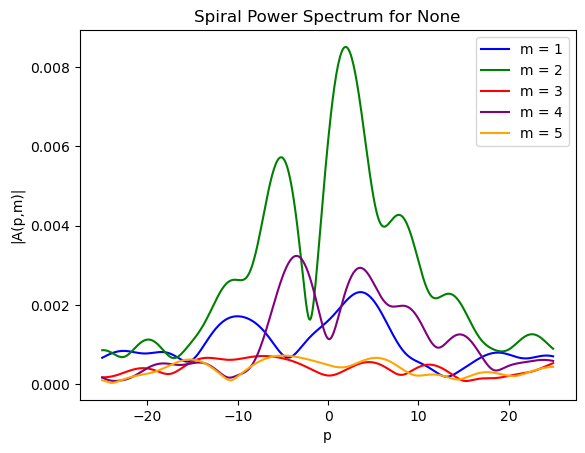

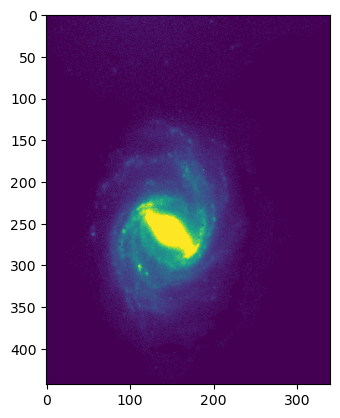

In [89]:
A, A_p_m, p, SN_w, p_max, SN_m, phi = gfits.Spiral_power_spec(tes_im,tes_tab,1.4,2)
dominant_mode = gfits.Number_of_arms(tes_im,tes_tab,1.4,True,False)

plt.figure()
#plt.axes('off')
plt.imshow(tes_im,vmin=1000,vmax=1200)

# Whats cool about this is you can see the mirroring in the 
# 4 arm componets where the sub arm branches are being detected <==== Speak to Steven is this something that could be of interest


In [90]:
import numpy as np
from astropy.io import fits

def save_spiral_power_spec(OBJID, band, band_index, A, A_p_m, p, SN_w, p_max, SN_m, phi):
    """This function assembles the outputs of Spiral_power_spec() function into a FITS table and saves it to disk

    Args:
        OBJID (str): ID of the object
        band (str): Name of the band
        band_index (int): Index of the band
        A (numpy array): Complex array representing the spiral Fourier transform of an image
        p (numpy array): Array of radial frequencies
        SN_w (numpy array): Signal-to-noise ratio for each radial frequency
        p_max (float): Radial frequency of the global maximum
        SN_m (float): Signal-to-noise ratio at the global maximum
        phi (float): Phase of the complex value at the global maximum

    Returns:
        (str): Filename of the saved FITS file
    """
    # Create FITS table
    hdu = fits.BinTableHDU.from_columns([
        fits.Column(name='abs(A)', format='D', array=A.real),
        fits.Column(name='A_real', format='D', array=A_p_m.real),
        fits.Column(name='A_imag', format='D', array=A_p_m.imag),
        fits.Column(name='p', format='D', array=p),
        fits.Column(name='SN_w', format='D', array=SN_w),
        fits.Column(name='p_max', format='D', array=[p_max]),
        fits.Column(name='SN_m', format='D', array=[SN_m]),
        fits.Column(name='phi', format='D', array=[phi])
    ])

    # Add header information
    hdu.header['OBJID'] = OBJID
    hdu.header['BAND'] = band
    hdu.header['BANDINDX'] = band_index

    # Save FITS file
    filename = f'{OBJID}_{band}_{band_index}.fits'
    hdu.writeto(filename, overwrite=True)

    return filename, hdu


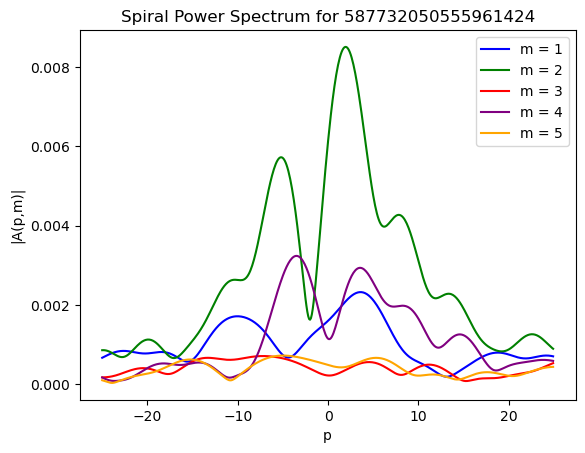

In [116]:
A, A_p_m, p, SN_w, p_max, SN_m, phi = gfits.Spiral_power_spec(tes_im,tes_tab,1.4,2)
dominant_mode = gfits.Number_of_arms(tes_im,tes_tab,1.4,True,False,objid='587732050555961424')
OBJID = '587732050555961424'
band = 'r'
band_index = 2
fname, hdu = save_spiral_power_spec(OBJID, band, band_index, A, A_p_m, p, SN_w, p_max, SN_m, phi)
hdu

In [92]:
tab = gfits.Read_Table('/home/borge/spiral_arms/George/587732050555961424_r_2.fits')
tab

<Table length=500>
        abs(A)                 A_real         ...         phi        
       float64                float64         ...       float64      
--------------------- ----------------------- ... -------------------
0.0008585983010157044 -0.00012869882475442118 ... -46.468800714380066
0.0008598032284145647  0.00019960570061909475 ...                 0.0
0.0008592670844030162   0.0004983216490077266 ...                 0.0
0.0008570184478220695   0.0007222802787141535 ...                 0.0
0.0008531054326196431   0.0008384910344716244 ...                 0.0
0.0008475963812297118   0.0008312597791919825 ...                 0.0
0.0008405806424081788    0.000704272620690429 ...                 0.0
0.0008321694175063697  0.00047937448352294095 ...                 0.0
0.0008224966469636858   0.0001923885115980615 ...                 0.0
  0.00081171989052527  -0.0001131512774167196 ...                 0.0
                  ...                     ... ...                 ...
0.0010833919225556993  0.00039198910284697386 ...                 0.0
0.0010616871443493523   0.0007214557017169486 ...                 0.0
0.0010396469966101225   0.0009368314060932766 ...                 0.0
0.0010174893664579231   0.0010146169896178513 ...                 0.0
0.0009954414865778465    0.000952089487690916 ...                 0.0
0.0009737377008945556   0.0007659292125750222 ...                 0.0
0.0009526165856705803   0.0004881733991518123 ...                 0.0
0.0009323173346187665  0.00016044354969718154 ...                 0.0
0.0009130753485614046 -0.00017246099425034813 ...                 0.0
0.0008951170272628183 -0.00046858220442185894 ...                 0.0

In [93]:
# Need a way of seleting the highest A(p,m) but chosing p furthest from p_max
p = tab['p'].ravel()
p_max = tab['p_max']
A_r = tab['A_real']
A_i = tab['A_imag']*1j
A = A_r + A_i
print(A[0])
# Nice

(-0.00012869882475442118-0.0008488979061193902j)


In [94]:
# So argsort A and apply the sorting to p
mask = np.argsort(np.abs(A))
difference = p[mask] - p_max

In [95]:
difference

<Column name='p' dtype='float64' length=500>
 -19.00000000000027
-16.999999999999886
 -17.19999999999989
-16.899999999999885
 -17.29999999999989
-16.799999999999883
-17.399999999999892
-16.699999999999882
 -22.79999999999997
 -22.89999999999997
-22.699999999999967
 -22.99999999999997
                ...
  2.500000000000391
 1.4000000000003752
 2.4000000000003894
 1.5000000000003766
  2.300000000000388
  1.600000000000378
 2.2000000000003865
 1.7000000000003794
  2.100000000000385
 1.8000000000003809
 2.0000000000003837
 1.9000000000003823

In [96]:
# Why do we even need to plot the second arm?

# We don't.

In [97]:
# Need to create a function that will find the tangent at points along the line and then from that the normal through the point


# First will use find equation of line through two points

def line_equation(point1, point2):
    """
    Given two points, return the equation of the line that passes through them
    in slope-intercept form: y = mx + b
    """
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the slope (m)
    m = (y2 - y1) / (x2 - x1)

    # Calculate the y-intercept (b)
    c = y1 - m * x1

    # Return the equation of the line in slope-intercept form
    return m, c

def normal_to_line(m, c, point):
    """
    Given the slope (m), y-intercept (c), and a point a line passes through,
    return the slope and y-intercept of the line that is normal (perpendicular) to it and passes through the point.
    """
    # Calculate the negative reciprocal of the slope to get the slope of the normal line
    m_normal = -1 / m

    # Calculate the y-intercept of the normal line using the point it passes through
    x, y = point
    b_normal = y - m_normal * x

    # Return the slope and y-intercept of the normal line
    return m_normal, b_normal


def normal_from_points(x0,y0,x1,y1):
    """
    Calculates the normal vector of a line passing through two points.

    Args:
        x0 (float): The x-coordinate of the first point.
        y0 (float): The y-coordinate of the first point.
        x1 (float): The x-coordinate of the second point.
        y1 (float): The y-coordinate of the second point.

    Returns:
        Tuple[float, float]: A tuple containing the slope and y-intercept of the normal line
        to the line passing through (x0, y0) and (x1, y1). The normal line passes through the
        midpoint of the line segment connecting (x0, y0) and (x1, y1).

    Raises:
        ZeroDivisionError: If the line passing through (x0, y0) and (x1, y1) is vertical.
    """
    middle = (x0+((x1-x0)/2),y0+((y1-y0)/2))
    m,c= line_equation((x0,y0),(x1,y1))
    m_n, m_c = normal_to_line(m,c,middle)
        
    return m_n, m_c

# Now we can feed points along the spiral using the x,y outputs from gen_spiral


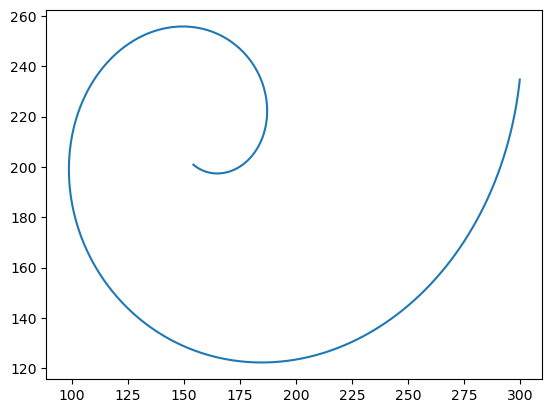

In [98]:

iso_im = gfits.Read('/home/borge/Data/Output_Data/Distributed_run/587732050555961424ra/0200/small_nonpar.fits') + 1000
org_im = gfits.Read('/home/borge/Data/Test_batch/587732050555961424ra.fits.gz')
source_table = gfits.Read_Table('/home/borge/Data/Output_Data/Distributed_run/587732050555961424ra/0200/source_params.fits')
x0 = source_table['x'] + iso_im.shape[1]/2     # Because of imshow flipping these are flipped
y0 = source_table['y'] + iso_im.shape[0]/2
R_e = 10**(np.asarray(Tab['log_re']))
A, A_p_m, p, SN_w, p_max, SN_m, phi = gfits.Spiral_power_spec(iso_im,source_table,0.3,2)
x,y, argument = gfits.gen_spiral(p_max,A_p_m,m,R_e,0.3,iso_im,x0,y0)
plt.plot(x,y) #check it looks like a spiral


# Stack x and y into an array 
points = np.vstack((x,y)).T


In [99]:
# Want to select 50 evenly spaced points along the line and create tangents and normals for them
num_samples = 50
samples = np.linspace(0,len(points)-1,num_samples,dtype=int)
#print(samples)
# Now sample the points using the spacing
tangent_points = points[samples]
print(tangent_points.shape)

# Now create an array of the indiciese above and below this 
# Need to mnake sure it doesn't sample outside the range at the top and bottom

bigger_r  = samples+1
smaller_r = samples-1
for i in range(0,len(bigger_r)):
    if bigger_r[i] >= len(points):
        bigger_r[i] = len(points)-1
    else:
        continue

# Now need to sample the points using the indices
big_point   = points[bigger_r]
small_point = points[smaller_r]
#print(big_point,small_point)


# Now need to create a set of line equations using the points
m_array = np.zeros(len(big_point))
c_array = np.zeros(len(big_point))

for i in range(0,len(big_point)):
    m_array[i], c_array[i] = normal_from_points(small_point[i,0],small_point[i,1],big_point[i,0],big_point[i,1])

(50, 2)


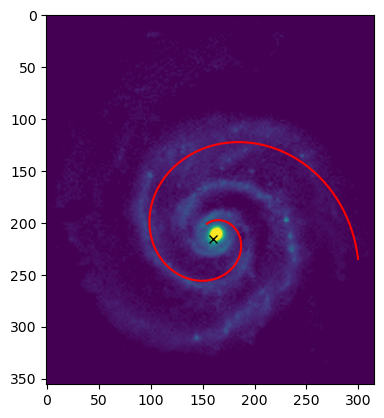

In [100]:
# Want to plot the normals on the image with the spiral fit overlay

plt.imshow(iso_im,vmin=1000,vmax=1200)
plt.plot(x,y,'r')
plt.plot(x0,y0,'xk')

(0.0, 356.0)

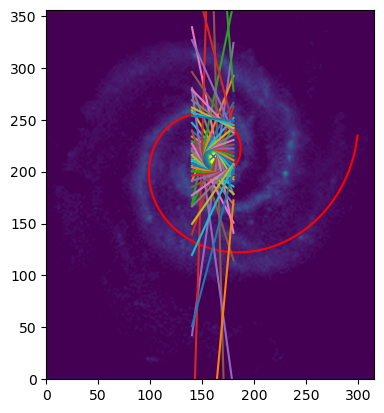

In [101]:
# Cool so now want to add the normal lines to the image

plt.imshow(iso_im,vmin=1000,vmax=1200)
plt.plot(x,y,'r')
plt.plot(x0,y0,'x')

# Need to create an x array centered around the line at each point
x_norm = np.linspace(x0-20,x0+20,100)

for i in range(0,len(m_array)):
    y_norm = m_array[i]*x_norm  + c_array[i]
    plt.plot(x_norm,y_norm)

plt.xlim(0,iso_im.shape[1])
plt.ylim(0,iso_im.shape[0])
# Getting closer

(0.0, 356.0)

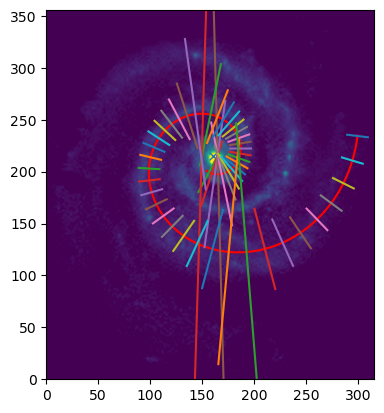

In [102]:
# The problem here is the x range needs to be spread around the point

# Cool so now want to add the normal lines to the image

plt.imshow(iso_im,vmin=1000,vmax=1200)
plt.plot(x,y,'r')
plt.plot(x0,y0,'x')


# Need to create an x array centered around the line at each point

for i in range(0,len(m_array)):
    x_norm = np.linspace(tangent_points[i,0]-10,tangent_points[i,0]+10,40)
    y_norm = m_array[i]*(x_norm) + c_array[i] 
    plt.plot(x_norm,y_norm)

plt.xlim(0,iso_im.shape[1])
plt.ylim(0,iso_im.shape[0])

# Need to limit the line length but looking good
# Will do this by limit the radius from the tangent 
# point similar to spiral trimming



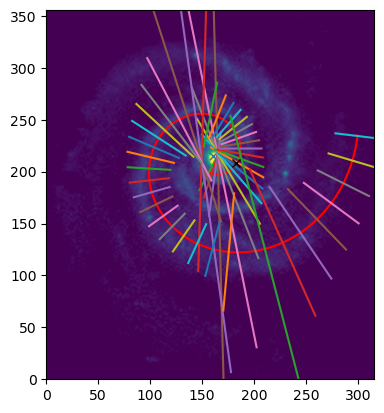

In [103]:
# Generate Image and overlay spiral
plt.imshow(iso_im,vmin=1000,vmax=1200)
plt.plot(x,y,'r')
plt.plot(x0,y0,'x')


# Add normals
for i in range(0,len(m_array)):
    x_norm = np.linspace(tangent_points[i,0]-10*(2-np.arctan(m_array[i])),tangent_points[i,0]+10*(2-np.arctan(m_array[i])),50)
    y_norm = m_array[i]*(x_norm) + c_array[i] 
    
    
    # Trim the longer lines
    if np.sqrt((x_norm[i] - tangent_points[i,0])**2 + (y_norm[i] + tangent_points[i,1])**2) > 100:
        x_norm[1:len(x_norm)-1]
        y_norm[1:len(y_norm)-1]
    else:
        continue
    
    plt.plot(x_norm,y_norm)

# Limit the range to the image
plt.xlim(0,iso_im.shape[1])
plt.ylim(0,iso_im.shape[0])
plt.plot(183,208,'kx')
# This isn't working so instead will scale the length  based on the gradient

(0.0, 356.0)

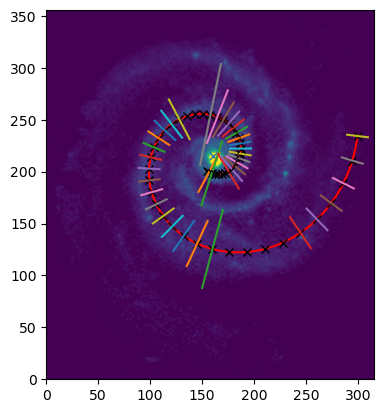

In [104]:
# Generate Image and overlay spiral
plt.imshow(iso_im,vmin=1000,vmax=1200)
plt.plot(x,y,'r')
plt.plot(x0,y0,'x')
L_lim=1000 #length in pixels
L_arr = np.empty_like(m_array)
# Add normals
for i in range(0,len(m_array)):

    x_norm = np.linspace(tangent_points[i,0]-10,tangent_points[i,0]+10,50)
    plt.plot(tangent_points[i,0],tangent_points[i,1],"kx")
    
    # Calculate the length of the lines
    L = 2*np.sqrt((10)**2 + (m_array[i]*(10))**2 + c_array[i]**2 + 2*m_array[i]*(10)*c_array[i])
    L_arr[i] = L
    if (L>L_lim):
        continue
    else:
        y_norm = m_array[i]*(x_norm) + c_array[i] 
        plt.plot(x_norm,y_norm)

# Limit the range to the image
plt.xlim(0,iso_im.shape[1])
plt.ylim(0,iso_im.shape[0])


In [105]:
L_arr, np.max(L_arr), np.min(L_arr)
# Can we make all of these the same size by varying powers of 10?

# Does it matter if they are too long when we just want to sample pixels from these lines?

(array([ 2298.24935167,   156.30198335,   523.39050361,  1748.76996815,
        12147.40172102,  1968.25019836,  1228.85292157,   953.20100196,
          795.68759475,   691.60423338,   616.06369496,   552.41853955,
          496.71300349,   444.72927918,   394.78724677,   340.66276215,
          279.98893542,   209.29915327,   113.94707688,    36.99684901,
          278.90774957,   928.39075672,  8786.40045522,  2443.25928803,
         1292.12617816,   951.30162896,   779.47544839,   672.90147271,
          592.10221522,   526.75935843,   471.16177268,   417.3630402 ,
          363.70117001,   308.62817913,   244.74812539,   167.78140237,
           71.65866711,    79.57153612,   324.97801855,   877.9251718 ,
         3335.51876994,  4773.06406981,  1799.41735657,  1235.32715918,
          977.85587516,   828.82127813,   730.50599749,   654.08997511,
          592.1269058 ,   539.29215123]),
 12147.401721023809,
 36.99684901129898)

In [106]:
def get_pixels_on_line_bad(image, m, c): #This didn't work... so I wrote it again
    # Bresenham's line algorithm
    width, height = image.shape[:2]
    
    if abs(m) > 1:
        y0 = 0
        y1 = height-1
        x0 = int(round((y0-c)/m))
        x1 = int(round((y1-c)/m))
    else:
        x0 = 0
        x1 = width-1
        y0 = int(round(m*x0 + c))
        y1 = int(round(m*x1 + c))

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    pixels_on_line = []
    while True:
        pixels_on_line.append((x0,y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return pixels_on_line

def get_pixels_on_line(normal_intersect, m, c,pixels): #passed in the coordinates of the spiral-lin-line intercept
    """
    Computes an array of pixel coordinates that lie on a line passing through a given point
    and having a specified slope and y-intercept.

    Args:
        normal_intersect (Tuple[int, int]): A tuple containing the x and y coordinates of
            the point where the line intersects a normal line passing through the center of
            a spiral.
        m (float): The slope of the line.
        c (float): The y-intercept of the line.
        pixels (int): The number of pixels on either side of the intersection point to compute.

    Returns:
        numpy.ndarray: A 2D numpy array of shape (2*pixels, 2) containing the (x, y) pixel
        coordinates that lie on the line, in order from left to right or from top to bottom
        depending on the steepness of the line.
    """
    #returns 'result' which is an array of pixel co-ordinates
    resulf=np.empty((2*pixels,2))
    if (abs(m)<1): #count along the X-axis as it's not steep
        n=0
        for my_x in range(normal_intersect[0]-pixels,normal_intersect[0]+pixels):
            resulf[n]=(my_x,m*my_x+c)
            n=n+1
        
    else: #this is steep,so work in the y dimension
        n=0
        for my_y in range (normal_intersect[1]-pixels,normal_intersect[1]+pixels):
            resulf[n]=(((my_y-c)/m),my_y)
            n=n+1
        resulf = np.flip(resulf,axis=0)
    result=resulf.astype(int)
    return result
    
    

def trim_pixels_on_line(pixels_on_line, chosen_pixel, trim_size):
    # Find the index of the chosen pixel in the pixels_on_line array
    index = np.where(np.all(np.array(pixels_on_line) == chosen_pixel, axis=1))[0][0]
    
    # Select a slice of the array centered around the chosen pixel
    start_index = max(index - trim_size, 0)
    end_index = min(index + trim_size + 1, len(pixels_on_line))
    trimmed_pixels_on_line = pixels_on_line[start_index:end_index]
    
    return trimmed_pixels_on_line


def trim_line(pixels_on_line,intersect,length):
    
    # Get intersection point as an index of the pixels on line array
    index_in_pixels_array = np.argwhere(pixels_on_line=intersect)
    
    


1 :Intersect  [156 199]
2 :Intersect  [159 198]
3 :Intersect  [162 197]
4 :Intersect  [165 197]
5 :Intersect  [168 197]
6 :Intersect  [172 198]
7 :Intersect  [175 200]
8 :Intersect  [178 202]
9 :Intersect  [181 205]
10 :Intersect  [183 208]
11 :Intersect  [185 212]
12 :Intersect  [186 217]
13 :Intersect  [187 222]
14 :Intersect  [186 227]
15 :Intersect  [185 232]
16 :Intersect  [183 237]
17 :Intersect  [179 242]
18 :Intersect  [175 246]
19 :Intersect  [170 250]
20 :Intersect  [164 252]
21 :Intersect  [158 254]
22 :Intersect  [150 255]
23 :Intersect  [143 255]
24 :Intersect  [135 253]
25 :Intersect  [128 250]
26 :Intersect  [120 245]
27 :Intersect  [114 239]
28 :Intersect  [108 232]
29 :Intersect  [103 223]
30 :Intersect  [100 213]
31 :Intersect  [ 98 202]
32 :Intersect  [ 99 191]
33 :Intersect  [101 180]
34 :Intersect  [105 168]
35 :Intersect  [112 157]
36 :Intersect  [121 147]
37 :Intersect  [132 138]
38 :Intersect  [130 145]
39 :Intersect  [125 160]
40 :Intersect  [122 175]
41 :Inter

(0.0, 356.0)

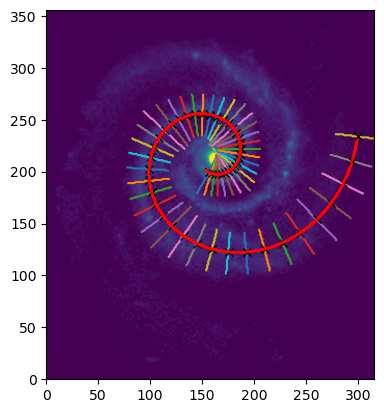

In [107]:
# Now want to combine these into one function that gets the values from the returned pixel indices

# First get pixels of the spiral
spiral_pixels = points.astype(int)
#print(spiral_pixels)
#spiral_pixels = spiral_pixels.tolist()
# Now get pixels along the normal
for selected in range(1,len(tangent_points)):
    arr = get_pixels_on_line(tangent_points[selected].astype(int),m_array[selected],c_array[selected],20)
    arr = np.asarray(arr).astype(int)
    #print(arr)

    mask = (spiral_pixels[:, None] == tangent_points[selected].astype(int)).all(-1).any(1)
    intersect  = np.unique(spiral_pixels[mask])
    #print(tangent_points[0,:].astype(int))
    print(selected,":Intersect ",intersect)

    # Get intersection point as an index of the pixels on line array
    index_in_pixels_array = np.argwhere(arr == intersect)
    #print("Index ",index_in_pixels_array)
    #print("Arr ",arr[index_in_pixels_array])

    mask = (arr[:, None] == tangent_points[selected].astype(int)).all(-1).any(1)
    index = arr[mask]
    plt.imshow(iso_im,vmin=1000,vmax=1200)
    plt.plot(x,y,'r')
    plt.plot(arr[:,0],arr[:,1])
    plt.plot(tangent_points[selected,0],tangent_points[selected,1],"kx")
    #print(arr[intersect[0]])
    #tangent_points[selected].astype(int), arr[intersect[0]], iso_im.shape, 
    
plt.xlim(0,iso_im.shape[1])
plt.ylim(0,iso_im.shape[0])

In [108]:
# Now wish to make a function which does this and then samples the pixels into arrays separately
# for graph plotting and then stacks them into an image

# First will attempt this with just one output

for selected in range(1,2):
    array = get_pixels_on_line(tangent_points[selected].astype(int),m_array[selected],c_array[selected],20)

line_pixel_values = np.empty(len(array))
    
for i in range(0,array.shape[0]):
    line_pixel_values[i] = iso_im[array[i,0],array[i,1]]
    
line_pixel_values    # Nice!

array([1012.05196602, 1009.29041166, 1013.6210929 , 1021.92692315,
       1023.00919098, 1015.87418026, 1008.66238242, 1006.49081569,
       1007.791502  , 1003.43310464, 1005.01921322, 1002.43988105,
       1001.59960529, 1003.25430411, 1004.13039548, 1005.32999208,
       1007.63610233, 1007.24974509, 1007.29489869, 1009.90256089,
       1011.74219536, 1014.18957397, 1009.56899371, 1007.34626441,
       1008.10548404, 1008.71110661, 1012.0394639 , 1010.94313083,
       1007.97230315, 1010.93022532, 1015.18143083, 1014.04342774,
       1005.83678154, 1000.        , 1001.1807585 , 1005.17065281,
       1005.72107844, 1006.06450607, 1005.92943578, 1012.53470041])

Text(0, 0.5, 'Log length along spiral fit')

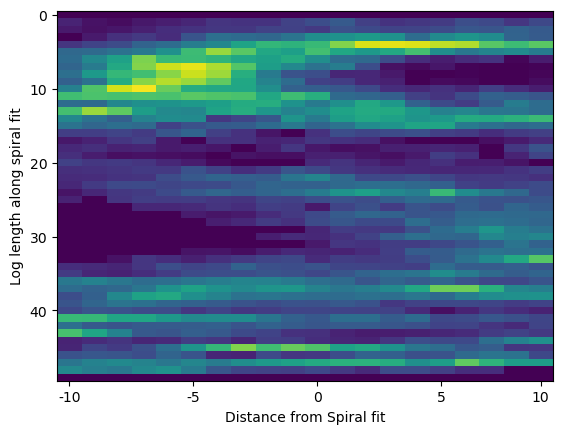

In [109]:
# Now generalising:
half_line_width = 10
quarter_line_width = half_line_width/2
three_quarter_line_width = 3*quarter_line_width
line_width = half_line_width*2

stacked_line_pixels = np.zeros((line_width,len(tangent_points)))

for j in range(1,len(tangent_points)):
    array = get_pixels_on_line(tangent_points[j].astype(int),m_array[j],c_array[j],half_line_width)
    
    line_pixel_values = np.empty(len(array))
    
    for i in range(0,array.shape[0]):
        line_pixel_values[i] = iso_im[array[i,0],array[i,1]]
    
    stacked_line_pixels[:,j] = line_pixel_values



plt.imshow(stacked_line_pixels.T,vmin=1000,vmax=1050,aspect='auto') #,origin='lower' This is quite amazing!
#plt.vlines(20,0,49,'k')
plt.xticks([0,half_line_width/2,half_line_width,half_line_width*1.5,line_width-1],['-{}'.format(half_line_width),'-{}'.format(int(quarter_line_width)),'0','{}'.format(int(quarter_line_width)),'{}'.format(half_line_width)])
plt.xlabel('Distance from Spiral fit')
plt.ylabel('Log length along spiral fit')

Text(0, 0.5, 'Flux')

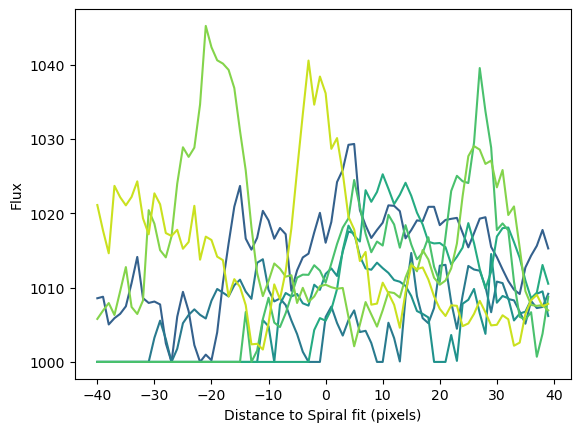

In [110]:
# now want to plot each individually on a graph

half_line_width = 40

# First create an array to plot against of distance from arm fit center
distance_to_fit = np.arange(-half_line_width,half_line_width,1) 

colours =  plt.cm.viridis(np.linspace(0,1,len(tangent_points)))

plt.figure()

for j in range(1,len(tangent_points)):
    array = get_pixels_on_line(tangent_points[j].astype(int),m_array[j],c_array[j],half_line_width)
    
    line_pixel_values = np.empty(len(array))
    
    for i in range(0,array.shape[0]):
        line_pixel_values[i] = iso_im[array[i,0],array[i,1]]
    
    
    if j > 10 and j%5 == 0:
        plt.plot(distance_to_fit,line_pixel_values,color=colours[j])
    else: 
        continue
    
    
plt.xlabel('Distance to Spiral fit (pixels)')
plt.ylabel('Flux')



In [111]:
# Want to make this into a function now

# Collect functions for documentation

def get_pixels_on_line(normal_intersect, m, c,pixels): #passed in the coordinates of the spiral-lin-line intercept
    #returns 'result' which is an array of pixel co-ordinates
    resulf=np.empty((2*pixels,2))
    if (abs(m)<1): #count along the X-axis as it's not steep
        n=0
        for my_x in range(normal_intersect[0]-pixels,normal_intersect[0]+pixels):
            resulf[n]=(my_x,m*my_x+c)
            n=n+1
        resulf = np.flip(resulf,axis=0)
    else: #this is steep,so work in the y dimension
        n=0
        for my_y in range (normal_intersect[1]-pixels,normal_intersect[1]+pixels):
            resulf[n]=(((my_y-c)/m),my_y)
            n=n+1
    result=resulf.astype(int)
    return result

def get_normals(spiral_points,num_samples):
    """
    Computes the normal lines to a spiral at specified sample points.

    Args:
        spiral_points (numpy.ndarray): A 2D numpy array containing the (x, y) coordinates of
            points along the spiral curve.
        num_samples (int): The number of sample points to use for computing the normal lines.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]: A tuple containing three numpy
        arrays: the slope and y-intercept of the normal lines at each sample point, and the
        (x, y) coordinates of the sample points.

    """
    samples = np.linspace(0,len(points)-1,num_samples,dtype=int)
    
    tangent_points = spiral_points[samples]

    bigger_r  = samples+1
    smaller_r = samples-1
    for i in range(0,len(bigger_r)):
        if bigger_r[i] >= len(points):
            bigger_r[i] = len(points)-1
        else:
            continue

    big_point   = points[bigger_r]
    small_point = points[smaller_r]

    m_array = np.zeros(len(big_point))
    c_array = np.zeros(len(big_point))

    for i in range(0,len(big_point)):
        m_array[i], c_array[i] = normal_from_points(small_point[i,0],small_point[i,1],big_point[i,0],big_point[i,1])
        
    return m_array, c_array, tangent_points


def Spiral_normal_distributions(image,table,spiral_points,num_samples,half_line_width,plot,analysis):
    """
    Computes normal distributions along a spiral arm in an astronomical image.

    Parameters:
    -----------
    image : numpy.ndarray
        The input astronomical image.
    table : astropy.table.table.Table
        A table containing galaxy properties.
    spiral_points : numpy.ndarray
        An array of points on the spiral arm.
    num_samples : int
        Number of samples to be taken along the spiral arm.
    half_line_width : int
        Half-width of the line in pixels.
    plot : bool
        Whether or not to plot the output.
    analysis : bool
        Whether or not to perform an analysis on the plotted output.

    Returns:
    --------
    numpy.ndarray
        A transposed array of stacked pixel values representing the normal distributions.
    """ 
    # Get equations of normal lines using above function
    m_array, c_array, tangent_points = get_normals(spiral_points,num_samples)
        
    # Calculate distance of each tangent point in terms of R_e
    # First collect centers and R_e from table
    x0 = table['x'] + image.shape[1]/2
    y0 = table['y'] + image.shape[0]/2
    R_e = 10**(table['log_re'])
    
    # Loop through tangent points and calculate radius at each point
    radii_in_pixels = np.empty(len(tangent_points))
    for i in range(0,len(tangent_points)):
        radii_in_pixels[i] =  np.sqrt((x0-tangent_points[i,0])**2+(y0-tangent_points[i,1])**2)
    
    # Get tangent_points in terms of R_e
    radii_in_R_e = radii_in_pixels/R_e
    
    # Sample radii array to get y_ticks
    y_tick_samples = np.linspace(0,len(radii_in_R_e)-1,5).astype(int)
    y_ticks = radii_in_R_e[y_tick_samples]
    y_tick_labels = np.array(['{}'.format(np.around(y_ticks[0],1)),
                              '{}'.format(np.around(y_ticks[1],1)),
                              '{}'.format(np.around(y_ticks[2],1)),
                              '{}'.format(np.around(y_ticks[3],1)),
                              '{}'.format(np.around(y_ticks[4],1))])
    
    # Set up Params for x_ticks
    quarter_line_width = half_line_width/2
    line_width = half_line_width*2

    # Stack sampled pixels into image
    stacked_line_pixels = np.zeros((line_width,len(tangent_points)))

    for j in range(1,len(tangent_points)):
        array = get_pixels_on_line(tangent_points[j].astype(int),m_array[j],c_array[j],half_line_width)
        
        line_pixel_values = np.empty(len(array))
        
        for i in range(0,array.shape[0]):
            line_pixel_values[i] = iso_im[array[i,0],array[i,1]]
        
        stacked_line_pixels[:,j] = line_pixel_values
    
    stacked_line_pixels = stacked_line_pixels.T
    
    # Plotting section
    
    if plot == True:
        colours =  plt.cm.plasma(np.linspace(0,1,len(tangent_points)))
        
        plt.figure()
        plt.imshow(image,vmin=1000,vmax=1200)
        plt.plot(spiral_points[:,0],spiral_points[:,1],'r')
        plt.xlim(0,image.shape[1])
        plt.ylim(0,image.shape[0])
        plt.axis('off')
        
        for i in range(1,len(tangent_points)):
            arr = get_pixels_on_line(tangent_points[i].astype(int),m_array[i],c_array[i],half_line_width)
            arr = np.asarray(arr).astype(int)
            
            if analysis == True:
                if i%10 == 0:
                    plt.plot(arr[:,0],arr[:,1],c='k')
                else:
                    continue
                    
            else:
                plt.plot(arr[:,0],arr[:,1],c=colours[i])

            
        plt.figure()
        plt.imshow(stacked_line_pixels,vmin=1000,vmax=1100,aspect='auto',origin='lower') # This is quite amazing!
        plt.xticks([0,half_line_width/2,half_line_width,half_line_width*1.5,line_width-1],
                   ['-{}'.format(half_line_width),'-{}'.format(int(quarter_line_width)),'0',
                    '{}'.format(int(quarter_line_width)),'{}'.format(half_line_width)])
        plt.yticks(y_tick_samples,y_tick_labels)
        plt.xlabel('Distance from Spiral fit (pixels)')
        plt.ylabel('Radial Distance/ $R_e$ ')
        if analysis == True:
            plt.hlines(np.arange(0,len(tangent_points),10),0,stacked_line_pixels.shape[1]-1,colors='k')
    
    return stacked_line_pixels.T
        


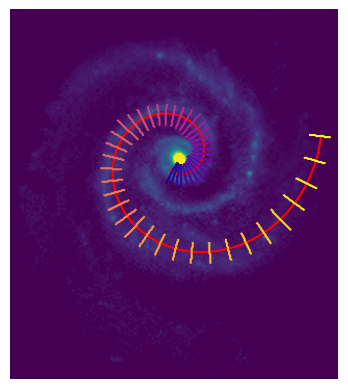

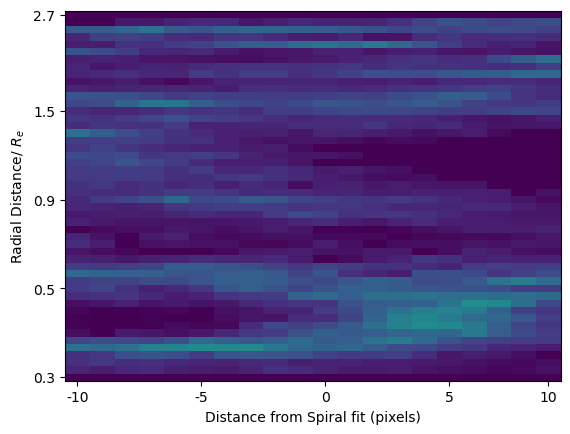

In [112]:

x,y, argument = gfits.gen_spiral(p_max,A_p_m,2,R_e,0.3,iso_im,x0,y0)

spiral_points = np.vstack((x,y)).T

arm_dist_image = Spiral_normal_distributions(iso_im,source_table,spiral_points,50,10,True,False)


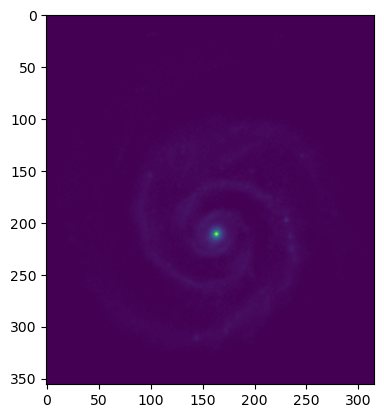

In [113]:
image = gfits.Read('/home/borge/Data/Output_Data/Distributed_run/587732050555961424ra/0200/small_nonpar.fits') # 587732050555961424 - NGC 2857
plt.imshow(image)

table = gfits.Read_Table('/home/borge/Data/Output_Data/Distributed_run/587732050555961424ra/0200/source_params.fits')

In [114]:
m = gfits.Number_of_arms(image,table,1,True,False) #m is an integer
phi, theta = gfits.Spiral_Fourier_Transform(image,table,1,m,True,False)

ValueError: Big-endian buffer not supported on little-endian compiler